# CH5 优化TensorFlow自编码器

所有监督学习都面临着一个巨大问题：维度灾难，即随着输入空间维度的增加，模型的性能逐渐变差。为克服这一问题，出现了一些优化网络。
* 第一种优化网络是**自编码器网络**。这种网络的设计和训练目的在于，转换自身输入模式，使得给出降级的或不完整的输入模式时，可以还原出原本的模式。其输出要尽可能复现输入；其隐藏层存储了压缩的数据，即数据的一个致密表示，其中包含输入数据的最基本特征。
* 第二种优化网络是**玻尔兹曼机**。这种网络包含一个输入/输出可见层和一个隐藏层。可见层与隐藏层之间的连接是无向的：数据可以在可见层-隐藏层和隐藏层-可见层两个方向游动，且不同的神经单元可以全连接或部分连接。
* 和自编码器类似的还有**主成分分析**。主成分分析用更少的维度表示给定输入。

可以关闭警告：`warnings.filterwarnings("ignore")`

## 5.1 自编码器简介

自编码器网络含有3个或3个以上网络层，其输入和输出层含有相同数量的神经元，而中间（隐藏）层的神经元数量较少。网络被训练用来重现输入，即输出与输入相同的模式。

该问题的重要意义在于，**由于隐藏层的神经元数量较少，所以如果网络可以从样本中学习并可以在一定程度上泛化，那么该网络就可以对数据进行压缩**：隐藏神经元的状态为每个样本提供了输入/输出的一个压缩版本。

*详情请见杰弗里·辛顿和鲁斯兰·萨拉赫丁诺夫的论文：Reducing the Dimensionality of Data with Neural Networks（2006）。
<br>地址为: https://www.cs.toronto.edu/~hinton/science.pdf。*

自编码器的几个有用的应用包括**数据去噪**和**用于数据可视化的维度约减**等。

一个自编码器的典型工作模式。它用两个阶段重建接收到的输入数据：编码阶段，对应对原始输入的降维；解码阶段，即从被编码（压缩）的数据中重建原始输入。
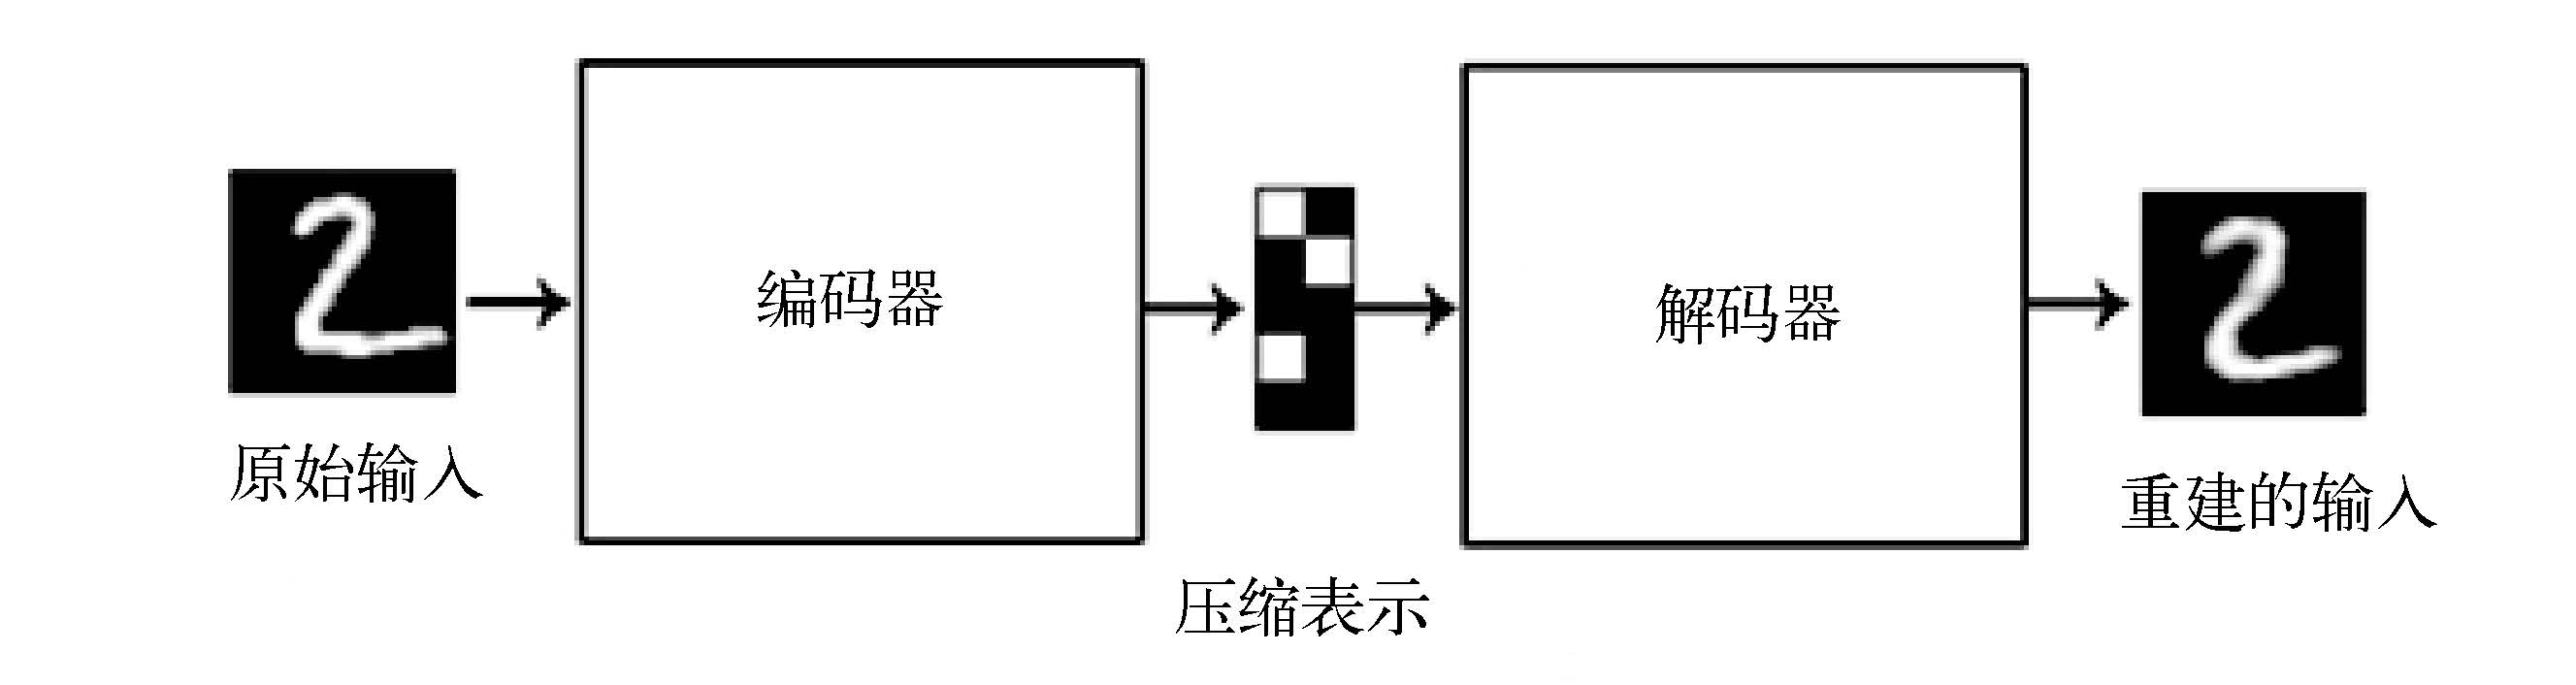

## 5.2 实现一个自编码器

训练一个自编码器的过程基本上很简单。它只是一个输出和输入相同的神经网络。自编码器的基本架构如下。

首先有一个输入层，紧接着有几个隐藏层，然后在一定的深度之后，隐藏层会变成相反的架构，直到我们达到一点，使得最后一层和输入层相同。将数据传入该网络，希望学习网络参数。

本例使用MNIST数据集中的图像

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data\t10k-images-idx3-ubyte.gz
Extracting data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
# 接着设置网络参数：
learning_rate = 0.01
training_epochs = 10
batch_size = 256
display_step = 1
examples_to_show = 4

In [3]:
# 隐藏特征的大小如下：
n_hidden_1 = 256
n_hidden_2 = 128

In [4]:
# 输入图像的大小如下：
n_input = 784
# 最终的大小为28 × 28 = 784像素。

我们要为输入图像定义占位符变量。该张量的数据类型设置为float，形状为`[None, n_input]`。None参数表示该张量中可以载入任意数量的图像：

In [5]:
X = tf.placeholder("float", [None, n_input])

In [6]:
# 然后，定义该网络的权重和偏差。权重数据结构包含编码器和解码器的权重定义。
# 注意，权重的初值用tf.random_normal选取，该函数返回服从正态分布的随机值：
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input]))
}

In [7]:
# 与之类似，定义网络偏差：
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}

将网络模型分为两个互补的、全连接的网络：一个编码器和一个解码器。

In [8]:
# 编码器负责编码数据。它从MNIST数据集载入一个输入图像X，然后对其进行编码：
encoder_in = tf.nn.sigmoid(tf.add(tf.matmul(X, weights['encoder_h1']), biases['encoder_b1']))

数据编码只是一个简单的矩阵乘法操作。输入数据X原本的维度为784，进行矩阵乘法后，被降低至256：

`(W*x + b) = encoder_in`

此处W是权重张量encoder_h1，b为偏差张量encoder_b1。

通过这种操作，将输入图像编码为自编码器的一个有用输入。编码的第二步就是数据的压缩。

In [9]:
# 由输入张量encoder_in表示的数据通过第二次矩阵乘法被降维到更小的大小：
encoder_out = tf.nn.sigmoid(tf.add(tf.matmul(encoder_in, weights['encoder_h2']), biases['encoder_b2']))

输入数据encoder_in的维度原本为256，现在被压缩至128：

`(W * encoder_in + b) = encoder_out`

此处W代表权重张量encoder_h2，b代表偏差张量encoder_b2。

注意，编码阶段使用的激活函数为sigmoid函数。

In [10]:
# 解码器进行的操作和编码器相反。它将输入数据解压缩，以获得和网络输入大小相同的输出。
# 该过程的第一个步骤是将大小为128的encoder_out张量转换为中间表示的张量，大小为256：
decoder_in = tf.nn.sigmoid(tf.add(tf.matmul(encoder_out, weights['decoder_h1']), biases['decoder_b1']))

上述代码用公式表示如下：

`(W * encoder_out + b) = decoder_in`

此处W表示权重张量decoder_h1，大小为256 × 128。b代表偏差张量decoder_b1，大小为256。

In [11]:
# 解码的最后一步是从中间表示（大小为256）中解压缩数据，生成最终的表示（大小为784）。
# 你应该可以想起，这就是原始输入数据的大小：
decoder_out = tf.nn.sigmoid(tf.add(tf.matmul(decoder_in, weights['decoder_h2']), biases['decoder_b2']))

In [12]:
# y_pred参数被设置为和decoder_out相等：
y_pred = decoder_out

In [13]:
# 如果输入数据X和被解码的数据相等，网络将会进行学习。因此，我们有如下定义：
y_true = X

In [14]:
# 自编码器的关键是生成一个约减矩阵，使其能够重建原始数据。
# 因此，需要最小化cost代价函数。然后，定义cost函数为y_true和y_pred之间的均方误差：
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))

In [15]:
# 为优化cost函数，使用下述RMSPropOptimizer类：
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

Epoch: 0001 cost= 0.439740092
Epoch: 0001 cost= 0.439897120
Epoch: 0001 cost= 0.439373791
Epoch: 0001 cost= 0.440842211
Epoch: 0001 cost= 0.441776633
Epoch: 0001 cost= 0.439729959
Epoch: 0001 cost= 0.439648837
Epoch: 0001 cost= 0.441044003
Epoch: 0001 cost= 0.440263748
Epoch: 0001 cost= 0.440593094
Epoch: 0001 cost= 0.440640122
Epoch: 0001 cost= 0.439940304
Epoch: 0001 cost= 0.439119220
Epoch: 0001 cost= 0.439725786
Epoch: 0001 cost= 0.439511508
Epoch: 0001 cost= 0.442035019
Epoch: 0001 cost= 0.439060628
Epoch: 0001 cost= 0.440706611
Epoch: 0001 cost= 0.441413641
Epoch: 0001 cost= 0.441010952
Epoch: 0001 cost= 0.440797657
Epoch: 0001 cost= 0.440106183
Epoch: 0001 cost= 0.440707058
Epoch: 0001 cost= 0.440603346
Epoch: 0001 cost= 0.441660345
Epoch: 0001 cost= 0.439522803
Epoch: 0001 cost= 0.439531624
Epoch: 0001 cost= 0.439849615
Epoch: 0001 cost= 0.439616561
Epoch: 0001 cost= 0.439456642
Epoch: 0001 cost= 0.438844770
Epoch: 0001 cost= 0.439006090
Epoch: 0001 cost= 0.439321786
Epoch: 000

D:\Python\Anaconda3\envs\GPU\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


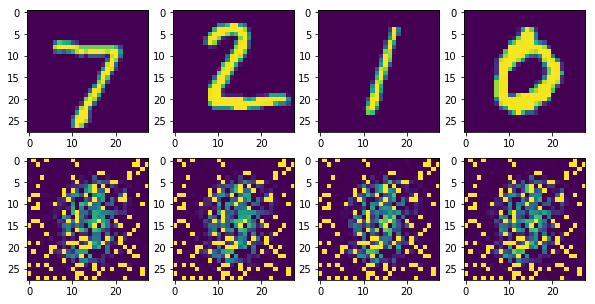

Epoch: 0002 cost= 0.206183493
Epoch: 0002 cost= 0.205081508
Epoch: 0002 cost= 0.206135511
Epoch: 0002 cost= 0.205627292
Epoch: 0002 cost= 0.204578906
Epoch: 0002 cost= 0.204937100
Epoch: 0002 cost= 0.204945505
Epoch: 0002 cost= 0.202578679
Epoch: 0002 cost= 0.203125045
Epoch: 0002 cost= 0.201937273
Epoch: 0002 cost= 0.201266333
Epoch: 0002 cost= 0.203394651
Epoch: 0002 cost= 0.199784636
Epoch: 0002 cost= 0.199982703
Epoch: 0002 cost= 0.200966254
Epoch: 0002 cost= 0.202024028
Epoch: 0002 cost= 0.200814381
Epoch: 0002 cost= 0.197736368
Epoch: 0002 cost= 0.197894499
Epoch: 0002 cost= 0.199068025
Epoch: 0002 cost= 0.199216798
Epoch: 0002 cost= 0.201437235
Epoch: 0002 cost= 0.199800923
Epoch: 0002 cost= 0.199124396
Epoch: 0002 cost= 0.199160755
Epoch: 0002 cost= 0.200146928
Epoch: 0002 cost= 0.200633988
Epoch: 0002 cost= 0.200177133
Epoch: 0002 cost= 0.198755220
Epoch: 0002 cost= 0.197971269
Epoch: 0002 cost= 0.197658718
Epoch: 0002 cost= 0.199009061
Epoch: 0002 cost= 0.198871061
Epoch: 000

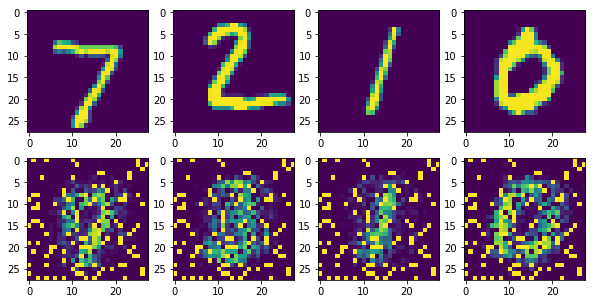

Epoch: 0003 cost= 0.171845764
Epoch: 0003 cost= 0.173802271
Epoch: 0003 cost= 0.169405118
Epoch: 0003 cost= 0.174141079
Epoch: 0003 cost= 0.170562118
Epoch: 0003 cost= 0.171730027
Epoch: 0003 cost= 0.169755816
Epoch: 0003 cost= 0.170011193
Epoch: 0003 cost= 0.171503901
Epoch: 0003 cost= 0.170333341
Epoch: 0003 cost= 0.173091635
Epoch: 0003 cost= 0.173193797
Epoch: 0003 cost= 0.171249345
Epoch: 0003 cost= 0.170563757
Epoch: 0003 cost= 0.168552980
Epoch: 0003 cost= 0.172719687
Epoch: 0003 cost= 0.171595946
Epoch: 0003 cost= 0.171735406
Epoch: 0003 cost= 0.170146823
Epoch: 0003 cost= 0.172093600
Epoch: 0003 cost= 0.169734761
Epoch: 0003 cost= 0.170188904
Epoch: 0003 cost= 0.172161952
Epoch: 0003 cost= 0.170617819
Epoch: 0003 cost= 0.171058699
Epoch: 0003 cost= 0.171355933
Epoch: 0003 cost= 0.168870911
Epoch: 0003 cost= 0.168840140
Epoch: 0003 cost= 0.166911691
Epoch: 0003 cost= 0.169597581
Epoch: 0003 cost= 0.170991600
Epoch: 0003 cost= 0.168289006
Epoch: 0003 cost= 0.169906765
Epoch: 000

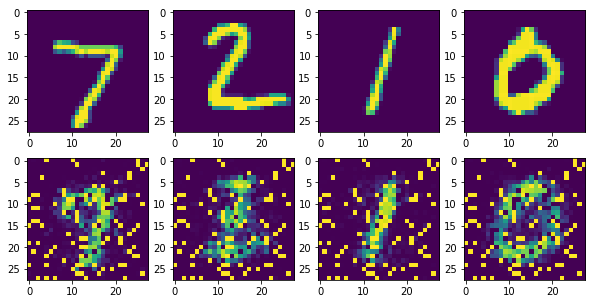

Epoch: 0004 cost= 0.150956586
Epoch: 0004 cost= 0.151079029
Epoch: 0004 cost= 0.153143689
Epoch: 0004 cost= 0.150453672
Epoch: 0004 cost= 0.153168917
Epoch: 0004 cost= 0.152246013
Epoch: 0004 cost= 0.150646329
Epoch: 0004 cost= 0.152593568
Epoch: 0004 cost= 0.151092708
Epoch: 0004 cost= 0.151553661
Epoch: 0004 cost= 0.150784299
Epoch: 0004 cost= 0.150268152
Epoch: 0004 cost= 0.149173841
Epoch: 0004 cost= 0.151323080
Epoch: 0004 cost= 0.150990486
Epoch: 0004 cost= 0.150991008
Epoch: 0004 cost= 0.149241254
Epoch: 0004 cost= 0.149595141
Epoch: 0004 cost= 0.150448620
Epoch: 0004 cost= 0.148375437
Epoch: 0004 cost= 0.149459049
Epoch: 0004 cost= 0.149849251
Epoch: 0004 cost= 0.150640354
Epoch: 0004 cost= 0.151222870
Epoch: 0004 cost= 0.151656076
Epoch: 0004 cost= 0.149300963
Epoch: 0004 cost= 0.149150953
Epoch: 0004 cost= 0.149791420
Epoch: 0004 cost= 0.151996970
Epoch: 0004 cost= 0.148886606
Epoch: 0004 cost= 0.151163161
Epoch: 0004 cost= 0.150060400
Epoch: 0004 cost= 0.154008612
Epoch: 000

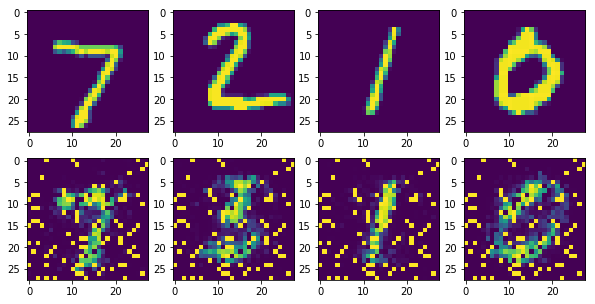

Epoch: 0005 cost= 0.145559758
Epoch: 0005 cost= 0.141618982
Epoch: 0005 cost= 0.142465249
Epoch: 0005 cost= 0.143047452
Epoch: 0005 cost= 0.144288063
Epoch: 0005 cost= 0.143334821
Epoch: 0005 cost= 0.142118827
Epoch: 0005 cost= 0.143329769
Epoch: 0005 cost= 0.141933545
Epoch: 0005 cost= 0.141507983
Epoch: 0005 cost= 0.141713604
Epoch: 0005 cost= 0.140778407
Epoch: 0005 cost= 0.142269313
Epoch: 0005 cost= 0.143772244
Epoch: 0005 cost= 0.141760588
Epoch: 0005 cost= 0.142930076
Epoch: 0005 cost= 0.142976582
Epoch: 0005 cost= 0.141412750
Epoch: 0005 cost= 0.140976399
Epoch: 0005 cost= 0.142576516
Epoch: 0005 cost= 0.143085256
Epoch: 0005 cost= 0.143065780
Epoch: 0005 cost= 0.146748036
Epoch: 0005 cost= 0.144033983
Epoch: 0005 cost= 0.143857777
Epoch: 0005 cost= 0.143121168
Epoch: 0005 cost= 0.143433109
Epoch: 0005 cost= 0.142475307
Epoch: 0005 cost= 0.143233478
Epoch: 0005 cost= 0.141802430
Epoch: 0005 cost= 0.141665891
Epoch: 0005 cost= 0.143808961
Epoch: 0005 cost= 0.143885031
Epoch: 000

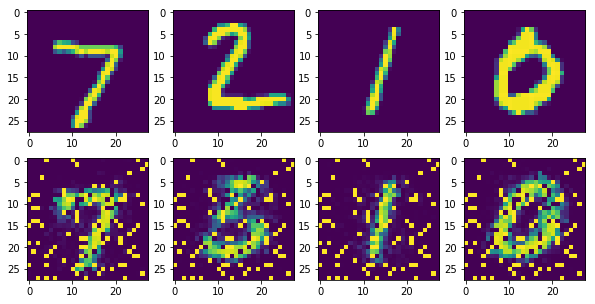

Epoch: 0006 cost= 0.138405755
Epoch: 0006 cost= 0.137052730
Epoch: 0006 cost= 0.136709571
Epoch: 0006 cost= 0.137531042
Epoch: 0006 cost= 0.137891442
Epoch: 0006 cost= 0.139459625
Epoch: 0006 cost= 0.138045862
Epoch: 0006 cost= 0.138633132
Epoch: 0006 cost= 0.140118212
Epoch: 0006 cost= 0.139541760
Epoch: 0006 cost= 0.140361413
Epoch: 0006 cost= 0.138291001
Epoch: 0006 cost= 0.138873339
Epoch: 0006 cost= 0.137196362
Epoch: 0006 cost= 0.137877718
Epoch: 0006 cost= 0.138135418
Epoch: 0006 cost= 0.139074951
Epoch: 0006 cost= 0.137952358
Epoch: 0006 cost= 0.138787434
Epoch: 0006 cost= 0.139920801
Epoch: 0006 cost= 0.136873037
Epoch: 0006 cost= 0.138382539
Epoch: 0006 cost= 0.137753934
Epoch: 0006 cost= 0.137881294
Epoch: 0006 cost= 0.137472034
Epoch: 0006 cost= 0.137114882
Epoch: 0006 cost= 0.138063148
Epoch: 0006 cost= 0.138405427
Epoch: 0006 cost= 0.138660133
Epoch: 0006 cost= 0.140359193
Epoch: 0006 cost= 0.140205249
Epoch: 0006 cost= 0.139133304
Epoch: 0006 cost= 0.138146862
Epoch: 000

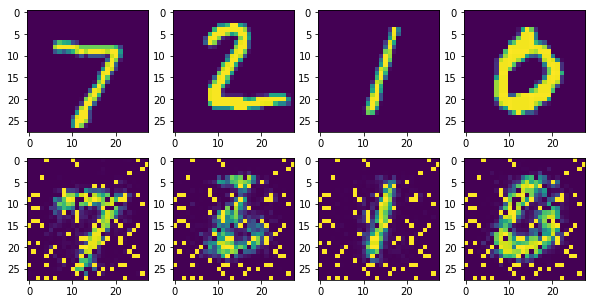

Epoch: 0007 cost= 0.136478454
Epoch: 0007 cost= 0.136487827
Epoch: 0007 cost= 0.137592807
Epoch: 0007 cost= 0.137874678
Epoch: 0007 cost= 0.135470435
Epoch: 0007 cost= 0.136346549
Epoch: 0007 cost= 0.136499137
Epoch: 0007 cost= 0.135932580
Epoch: 0007 cost= 0.136724159
Epoch: 0007 cost= 0.136706844
Epoch: 0007 cost= 0.137280330
Epoch: 0007 cost= 0.135770023
Epoch: 0007 cost= 0.136093155
Epoch: 0007 cost= 0.135261729
Epoch: 0007 cost= 0.135277256
Epoch: 0007 cost= 0.135847300
Epoch: 0007 cost= 0.135982811
Epoch: 0007 cost= 0.133055508
Epoch: 0007 cost= 0.134540483
Epoch: 0007 cost= 0.134502545
Epoch: 0007 cost= 0.134206459
Epoch: 0007 cost= 0.136674181
Epoch: 0007 cost= 0.138920993
Epoch: 0007 cost= 0.139156401
Epoch: 0007 cost= 0.137183636
Epoch: 0007 cost= 0.136600867
Epoch: 0007 cost= 0.137362435
Epoch: 0007 cost= 0.137424633
Epoch: 0007 cost= 0.136842787
Epoch: 0007 cost= 0.135629997
Epoch: 0007 cost= 0.134955928
Epoch: 0007 cost= 0.134691834
Epoch: 0007 cost= 0.135930493
Epoch: 000

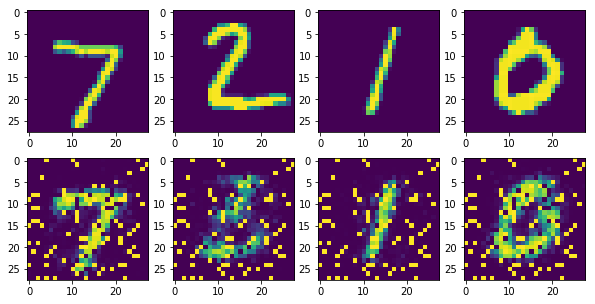

Epoch: 0008 cost= 0.131142914
Epoch: 0008 cost= 0.133691102
Epoch: 0008 cost= 0.133194163
Epoch: 0008 cost= 0.134405449
Epoch: 0008 cost= 0.133172035
Epoch: 0008 cost= 0.133132055
Epoch: 0008 cost= 0.134233519
Epoch: 0008 cost= 0.135253578
Epoch: 0008 cost= 0.132391542
Epoch: 0008 cost= 0.132362217
Epoch: 0008 cost= 0.133783981
Epoch: 0008 cost= 0.132981613
Epoch: 0008 cost= 0.130575344
Epoch: 0008 cost= 0.133483261
Epoch: 0008 cost= 0.132504791
Epoch: 0008 cost= 0.131907567
Epoch: 0008 cost= 0.133411795
Epoch: 0008 cost= 0.134128615
Epoch: 0008 cost= 0.132283211
Epoch: 0008 cost= 0.132779539
Epoch: 0008 cost= 0.131626710
Epoch: 0008 cost= 0.133895636
Epoch: 0008 cost= 0.133114994
Epoch: 0008 cost= 0.132297382
Epoch: 0008 cost= 0.131642863
Epoch: 0008 cost= 0.133430839
Epoch: 0008 cost= 0.131691724
Epoch: 0008 cost= 0.132540822
Epoch: 0008 cost= 0.131957039
Epoch: 0008 cost= 0.132088140
Epoch: 0008 cost= 0.130587250
Epoch: 0008 cost= 0.132039696
Epoch: 0008 cost= 0.132609859
Epoch: 000

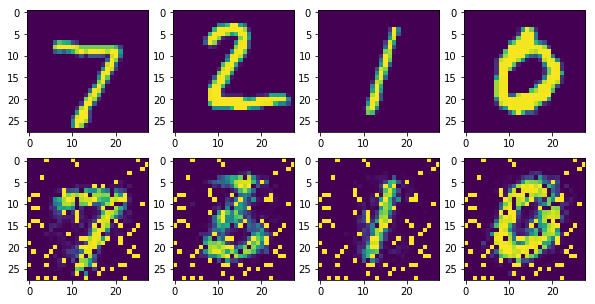

Epoch: 0009 cost= 0.127959117
Epoch: 0009 cost= 0.127690703
Epoch: 0009 cost= 0.127806649
Epoch: 0009 cost= 0.129706532
Epoch: 0009 cost= 0.130178347
Epoch: 0009 cost= 0.129627302
Epoch: 0009 cost= 0.128986239
Epoch: 0009 cost= 0.128039494
Epoch: 0009 cost= 0.126532912
Epoch: 0009 cost= 0.127347007
Epoch: 0009 cost= 0.129421249
Epoch: 0009 cost= 0.129513681
Epoch: 0009 cost= 0.129954353
Epoch: 0009 cost= 0.127461538
Epoch: 0009 cost= 0.127861932
Epoch: 0009 cost= 0.128174782
Epoch: 0009 cost= 0.127871215
Epoch: 0009 cost= 0.127495244
Epoch: 0009 cost= 0.128975973
Epoch: 0009 cost= 0.126618847
Epoch: 0009 cost= 0.128903985
Epoch: 0009 cost= 0.128019527
Epoch: 0009 cost= 0.129781201
Epoch: 0009 cost= 0.130267128
Epoch: 0009 cost= 0.128150553
Epoch: 0009 cost= 0.125994101
Epoch: 0009 cost= 0.124234676
Epoch: 0009 cost= 0.126090109
Epoch: 0009 cost= 0.126513690
Epoch: 0009 cost= 0.126191422
Epoch: 0009 cost= 0.128796399
Epoch: 0009 cost= 0.126898915
Epoch: 0009 cost= 0.127205983
Epoch: 000

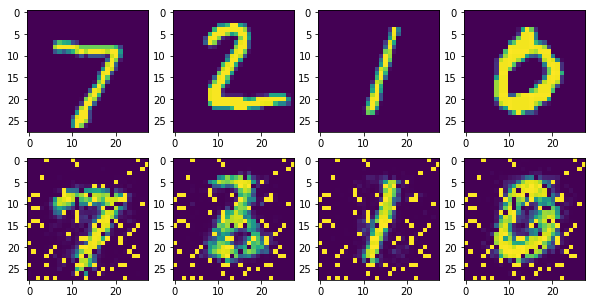

Epoch: 0010 cost= 0.128491595
Epoch: 0010 cost= 0.127432466
Epoch: 0010 cost= 0.126250148
Epoch: 0010 cost= 0.125749215
Epoch: 0010 cost= 0.125440747
Epoch: 0010 cost= 0.127761394
Epoch: 0010 cost= 0.128667578
Epoch: 0010 cost= 0.126291335
Epoch: 0010 cost= 0.126096010
Epoch: 0010 cost= 0.125652507
Epoch: 0010 cost= 0.126249105
Epoch: 0010 cost= 0.126335919
Epoch: 0010 cost= 0.126878187
Epoch: 0010 cost= 0.128098011
Epoch: 0010 cost= 0.128709912
Epoch: 0010 cost= 0.128247961
Epoch: 0010 cost= 0.127940029
Epoch: 0010 cost= 0.127299413
Epoch: 0010 cost= 0.125391394
Epoch: 0010 cost= 0.126532346
Epoch: 0010 cost= 0.126216292
Epoch: 0010 cost= 0.127378389
Epoch: 0010 cost= 0.126509175
Epoch: 0010 cost= 0.127163202
Epoch: 0010 cost= 0.126860514
Epoch: 0010 cost= 0.125456169
Epoch: 0010 cost= 0.127938390
Epoch: 0010 cost= 0.126425624
Epoch: 0010 cost= 0.125894561
Epoch: 0010 cost= 0.125644758
Epoch: 0010 cost= 0.126884028
Epoch: 0010 cost= 0.126587793
Epoch: 0010 cost= 0.125542596
Epoch: 001

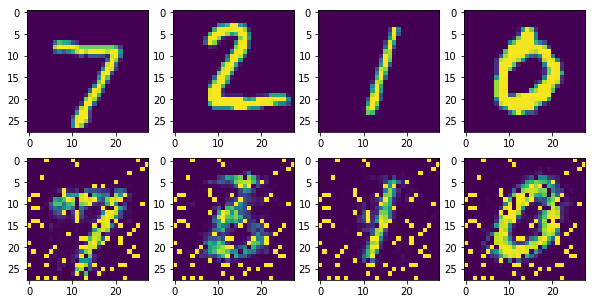

In [16]:
# 然后准备创建会话：
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    
    # 设置批图像的大小，以训练该网络：
    total_batch = int(mnist.train.num_examples/batch_size)
    
    # 开始训练循环（训练的时期数training_epochs被设置为10）：
    for epoch in range(training_epochs):
        #  在每个批内都进行循环：
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # 运行优化步骤，将批数据集batch_xs馈给执行图：
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
            
            # 显示每个训练时期的结果：
            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
        print("Optimization Finished!")
        # 最后运行编码和解码步骤，以测试该模型。将图像的一个子集馈给模型。此处example_to_show的值被设置为4：
        encode_decode = sess.run(y_pred, feed_dict={X: mnist.test.images[:examples_to_show]})
        
        # 使用matplotlib中的功能，比较原始图像与重构的图像：
        f, a = plt.subplots(2, 4, figsize=(10, 5))
        for i in range(examples_to_show):
            a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
            a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
        f.show()
        plt.draw()
        plt.show()

## 5.3 增强自编码器的鲁棒性
增强自编码器鲁棒性的一个成功方法是，**在编码阶段引入噪声**。实际上，我们将去噪自编码器称为“随机版本的自编码器”，**其中的输入是随机损坏的，而生成同一个输入的未损坏版本是解码阶段的目标**。

直观地说，一个去噪自编码器要完成两个任务：
* 第一，对输入编码并保留主要信息；
* 第二，降低甚至避免损坏输入的影响。

## 5.4 构建去噪自编码器
该网络的架构十分简单。一个大小为784像素的输入图像被随机损坏，然后用一个编码网络层对其进行降维。降维步骤将图像从784约减到256像素。

在解码阶段，我们为网络输出做准备，将原始图像的大小从256再变回784。

In [31]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

In [32]:
# 设置基本的网络参数：
n_input = 784
n_hidden_1 = 256
n_hidden_2 = 256
n_output = 784

In [33]:
# 还需设置会话的参数：
epochs = 110
batch_size = 100
disp_step = 10

In [34]:
# 构建训练和测试集。再次从安装包中自带的tensorflow.examples.tutorials.mnist库导入input_data特征：
print ("PACKAGES LOADED")
mnist = input_data.read_data_sets('data/', one_hot=True)
trainimg = mnist.train.images
trainlabel = mnist.train.labels
testimg = mnist.test.images
testlabel = mnist.test.labels
print ("MNIST LOADED")

PACKAGES LOADED
Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
MNIST LOADED


In [35]:
# 然后为输入图像定义占位符变量。数据类型被设置为float，形状为[None, n_input]。
# 参数None表示该张量中可以载入任意数量的图像，其中每个图像的大小为n_input：
x = tf.placeholder("float", [None, n_input])

In [36]:
y = tf.placeholder("float", [None, n_output])

In [37]:
# 为减少过拟合，我们在编码及解码过程之前使用dropout操作。
# 因此，必须为每个神经元的输出被保留的概率定义占位符变量：
dropout_keep_prob = tf.placeholder("float")

In [38]:
# 在这些定义的基础上，确定网络的权重和偏差：
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_output]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_output]))
}

权重和偏差由tf.random_normal选取。该函数返回服从正态分布的随机值。

In [39]:
# 编码阶段从MNIST数据集获取输入，然后进行数据压缩，也就是执行矩阵乘法操作：
encode_in = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
encode_out = tf.nn.dropout(encode_in, dropout_keep_prob)

In [40]:
# 在解码阶段应用同样的步骤：
decode_in = tf.nn.sigmoid(tf.add(tf.matmul(encode_out, weights['h2']), biases['b2']))
# 通过dropout过程减少过拟合现象：
decode_out = tf.nn.dropout(decode_in,dropout_keep_prob)

In [41]:
# 现在，创建预测张量y_pred：
y_pred = tf.nn.sigmoid(tf.matmul(decode_out, weights['out']) + biases['out'])

In [42]:
# 然后定义一个cost度量参数，以指导参数优化过程：
cost = tf.reduce_mean(tf.pow(y_pred - y, 2))

In [43]:
# 使用RMSPropOptimizer类，最小化cost函数：
optmizer = tf.train.RMSPropOptimizer(0.01).minimize(cost)

In [44]:
# 最后，初始化前面定义的变量：
init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [46]:
#Plot function
def plotresult(org_vec,noisy_vec,out_vec):
    plt.matshow(np.reshape(org_vec, (28, 28)), cmap=plt.get_cmap('gray'))
    plt.title("Original Image")
    plt.colorbar()

    plt.matshow(np.reshape(noisy_vec, (28, 28)), cmap=plt.get_cmap('gray'))
    plt.title("Input Image")
    plt.colorbar()
    
    outimg = np.reshape(out_vec, (28, 28))
    plt.matshow(outimg, cmap=plt.get_cmap('gray'))
    plt.title("Reconstructed Image")
    plt.colorbar()
    plt.show()

Start Training
Epoch 00/110 average cost: 0.211256
Start Test
Test label is 8


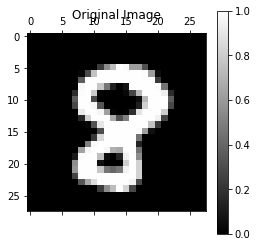

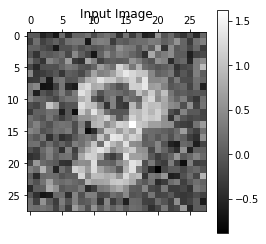

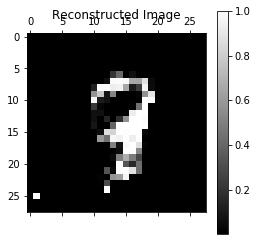

restart Training
Epoch 10/110 average cost: 0.034794
Start Test
Test label is 8


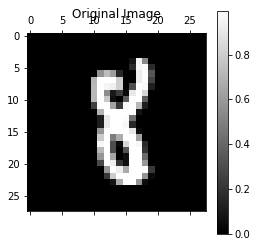

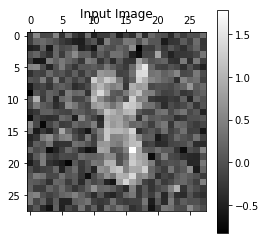

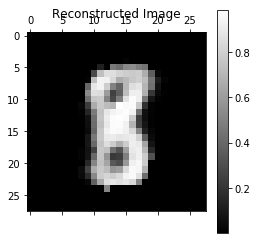

restart Training
Epoch 20/110 average cost: 0.027939
Start Test
Test label is 0


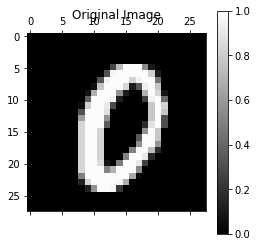

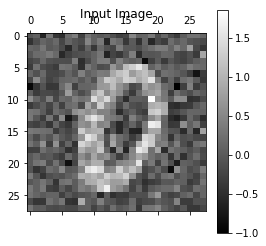

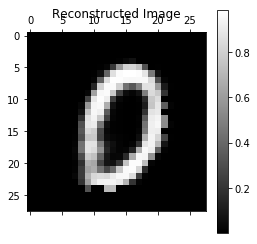

restart Training
Epoch 30/110 average cost: 0.024271
Start Test
Test label is 2


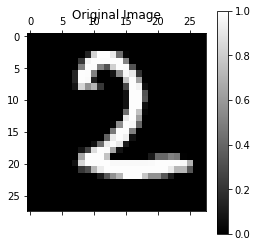

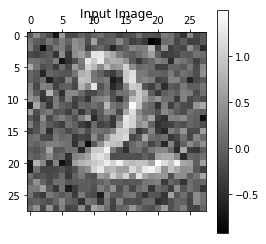

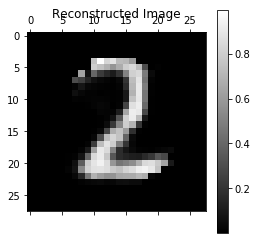

restart Training
Epoch 40/110 average cost: 0.021989
Start Test
Test label is 9


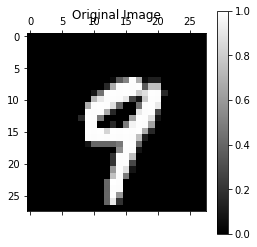

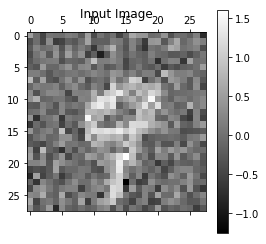

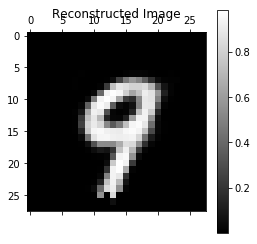

restart Training
Epoch 50/110 average cost: 0.020774
Start Test
Test label is 9


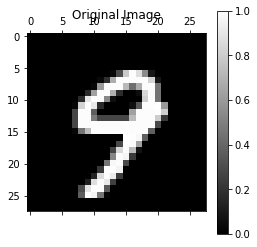

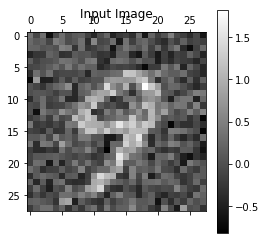

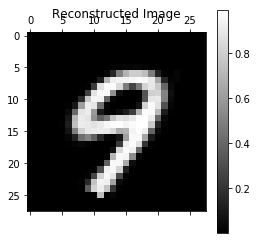

restart Training
Epoch 60/110 average cost: 0.019902
Start Test
Test label is 2


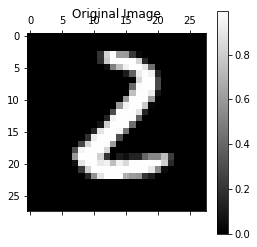

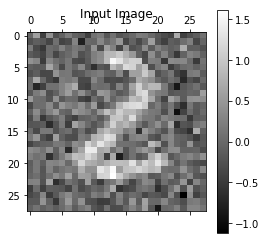

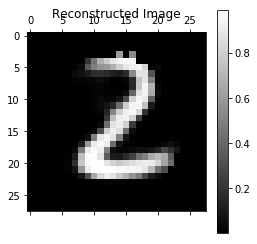

restart Training
Epoch 70/110 average cost: 0.019269
Start Test
Test label is 0


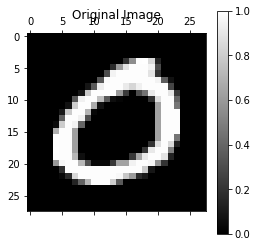

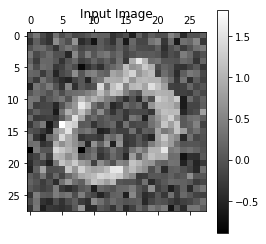

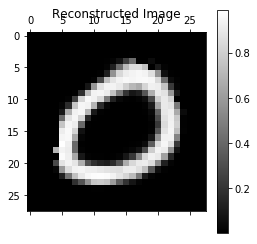

restart Training
Epoch 80/110 average cost: 0.018851
Start Test
Test label is 8


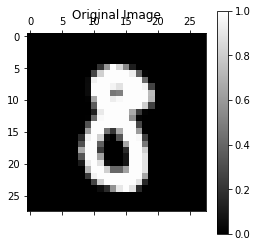

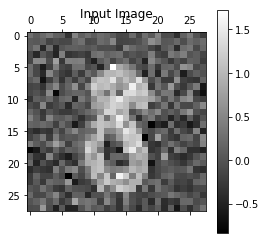

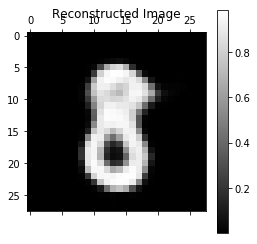

restart Training
Epoch 90/110 average cost: 0.018253
Start Test
Test label is 5


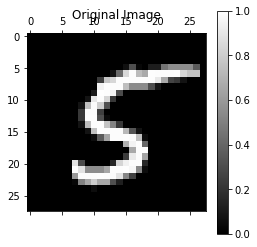

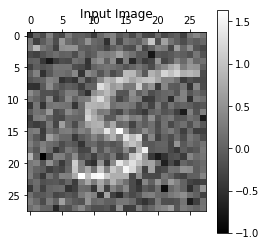

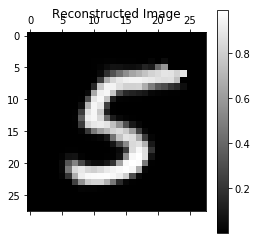

restart Training
Epoch 100/110 average cost: 0.017903
Start Test
Test label is 5


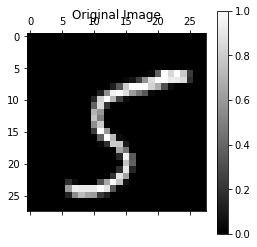

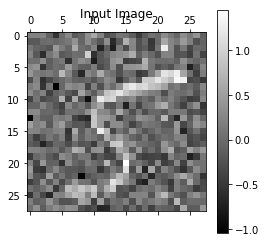

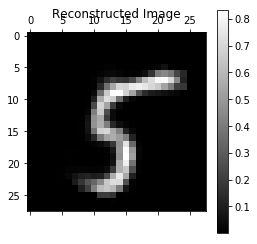

restart Training


In [47]:
# 接下来，设置TensorFlow运行会话：
with tf.Session() as sess:
    sess.run(init)
    print ("Start Training")
    for epoch in range(epochs):
        num_batch = int(mnist.train.num_examples/batch_size)
        total_cost = 0.
        for i in range(num_batch):
            # 在每个训练时期，从训练集中选择一小批数据集进行训练：
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # 这里有一个关键点：使用前面引入的numpy包中的random函数，随机损坏batch_xs数据集。
            batch_xs_noisy = batch_xs + 0.3*np.random.randn(batch_size, 784)
            # 将这些数据集馈给执行图，然后运行会话（sess.run）：
            feeds = {x: batch_xs_noisy, y: batch_xs, dropout_keep_prob: 0.8}
            sess.run(optmizer, feed_dict=feeds)
            total_cost += sess.run(cost, feed_dict=feeds)
        
        # 每过10个时期，程序会显示当前的平均代价值：
        if epoch % disp_step == 0:
            print ("Epoch %02d/%02d average cost: %.6f" % (epoch, epochs, total_cost/num_batch))
            
            # 最后，开始测试训练出的模型：
            print ("Start Test")
            # 为测试该模型，随机从测试集中选取一个图像：
            randidx = np.random.randint(testimg.shape[0], size=1)
            orgvec = testimg[randidx, :]
            testvec = testimg[randidx, :]
            label = np.argmax(testlabel[randidx, :], 1)
            
            print ("Test label is %d" % (label))
            noisyvec = testvec + 0.3*np.random.randn(1, 784)
            # 然后，在选出的图像上运行训练出的模型：
            outvec = sess.run(y_pred,feed_dict={x: noisyvec, dropout_keep_prob: 1})
            
            # 如你所见，下面的plotresult函数将会显示原始图像、噪声图像和预测图像：
            plotresult(orgvec,noisyvec,outvec)
            print ("restart Training")

## 5.5 卷积自编码器
目前为止，我们看到的自编码器输入都是图像。因此，你不免要问，卷积架构能否比前面讨论的自编码器架构性能更好。

### 5.5.1 编码器
编码器包含3个卷积层。特征的数量由输入数据的1，变为第一个卷积层的16，然后变为第二个卷积层的32，再变到最后一个卷积层的64。

从第一个卷积层向第二个卷积层转换时，图像的形状经历了压缩过程:
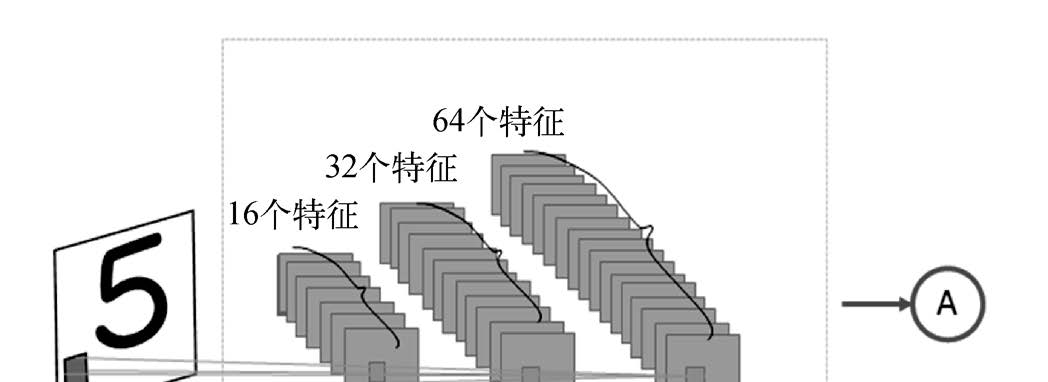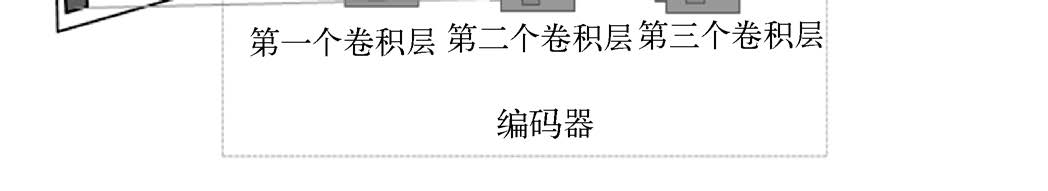

### 5.5.2 解码器
解码器包括3个按顺序排列的反卷积层。对每个反卷积操作，我们减少特征数量，以获取与原始图像大小相同的图像。除了要减少特征数量，反卷积还会改变图像的形状
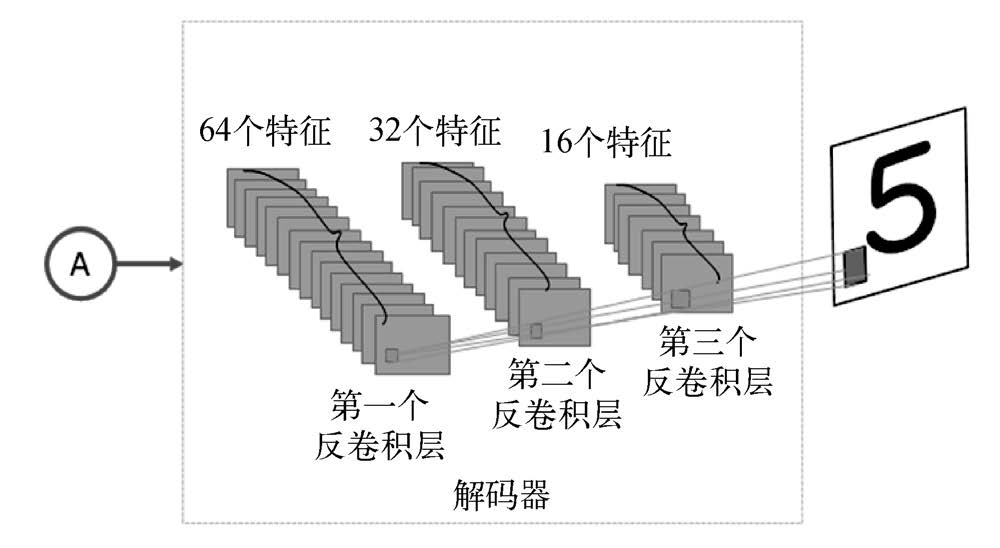

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data

In [49]:
# 然后创建训练和测试集：
mnist = input_data.read_data_sets("data/", one_hot=True)
trainimgs = mnist.train.images
trainlabels = mnist.train.labels
testimgs = mnist.test.images
testlabels = mnist.test.labels

ntrain = trainimgs.shape[0]     # 55000
ntest = testimgs.shape[0]    # 10000
dim = trainimgs.shape[1]    # 784
nout = trainlabels.shape[1]    # 10

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [50]:
# 为输入图像定义一个占位符变量：
x = tf.placeholder(tf.float32, [None, dim])

数据类型被设置为float32，形状为[None, dim]，其中**None表示该张量中可以载入任意数量的图像**，**每个图像为长度为dim的向量**。
<br>然后，为输出图像定义占位符变量。该变量的形状被设置为[None, dim]，和输入图像形状相同：

In [51]:
y = tf.placeholder(tf.float32, [None, dim])

In [52]:
# 然后定义keepprob变量，以设置神经网络训练过程中dropout的比例：
keepprob = tf.placeholder(tf.float32)

In [53]:
# 另外，还需要定义每个网络层的节点数量：
n1 = 16
n2 = 32
n3 = 64
ksize = 5    # 代表用5*5的卷积？

In [54]:
# 网络总共包含6个层。前三个层为用于编码的卷积层，后三个层为用于解码的反卷积层。
weights = {
    'ce1': tf.Variable(tf.random_normal([ksize, ksize, 1, n1],stddev=0.1)),
    'ce2': tf.Variable(tf.random_normal([ksize, ksize, n1, n2],stddev=0.1)),
    'ce3': tf.Variable(tf.random_normal([ksize, ksize, n2, n3],stddev=0.1)),
    
    'cd3': tf.Variable(tf.random_normal([ksize, ksize, n2, n3],stddev=0.1)),
    'cd2': tf.Variable(tf.random_normal([ksize, ksize, n1, n2],stddev=0.1)),
    'cd1': tf.Variable(tf.random_normal([ksize, ksize, 1, n1],stddev=0.1))
}

biases = {
    'be1': tf.Variable(tf.random_normal([n1], stddev=0.1)),
    'be2': tf.Variable(tf.random_normal([n2], stddev=0.1)),
    'be3': tf.Variable(tf.random_normal([n3], stddev=0.1)),
    
    'bd3': tf.Variable(tf.random_normal([n2], stddev=0.1)),
    'bd2': tf.Variable(tf.random_normal([n1], stddev=0.1)),
    'bd1': tf.Variable(tf.random_normal([1], stddev=0.1))
}

In [ ]:
# 下面的cae函数创建了卷积自编码器。传递的输入为图像_X、权重_W和偏差_b的数据结构，以及_keepprob参数：
def cae(_X, _W, _b, _keepprob):
    
    # 最初的图像为784像素，必须变形为大小为28 × 28的矩阵，供下一个卷积层进行进一步处理：
    _input_r = tf.reshape(_X, shape=[-1, 28, 28, 1])
    
    # 第一个卷积层为_ce1，其输入为_input_r张量，代表输入图像：
    _ce1 = tf.nn.sigmoid(tf.add(tf.nn.conv2d(_input_r, _W['ce1'], 
                                             strides=[1, 2, 2, 1], 
                                             padding='SAME'),
                                _b['be1']))
    
    # 在数据移动到第二层卷积之前，先进行dropout操作：
    _ce1 = tf.nn.dropout(_ce1, _keepprob)
    
    # 在接下来的两个编码层中，进行同样的卷积和dropout操作：
    _ce2 = tf.nn.sigmoid(tf.add(tf.nn.conv2d(_ce1, _W['ce2'],
                                             strides=[1, 2, 2, 1],
                                             padding='SAME'),
                                _b['be2']))
    _ce2 = tf.nn.dropout(_ce2, _keepprob)
    
    _ce3 = tf.nn.sigmoid(tf.add(tf.nn.conv2d(_ce2, _W['ce3'],
                                             strides=[1, 2, 2, 1],
                                             padding='SAME'),
                                _b['be3']))
    _ce3 = tf.nn.dropout(_ce3, _keepprob)

特征的数量从1（输入图像）增加至64，而原始图像的形状从28 × 28降至7 × 7。在解码阶段，压缩（或编码）并变形的图像必须尽可能与原始图像相同。

In [ ]:
# 为实现这一点，对接下来的3层使用TensorFlow函数conv2d_transpose：
tf.nn.conv2d_transpose(value, filter, output_shape, strides, padding='SAME')

这一过程有时称为反卷积。其实这仅仅是对conv2d的转置（求导）操作。

该函数的参数如下。
* value：类型为浮点型，形状为(批, 高度, 宽度, 输入通道)的四维张量。
* filter：类型与value相同，形状为(高度, 宽度, 输出通道, 输入通道)的四维张量。in_channels的维度必须和value相匹配。
* output_shape：一维张量，代表反卷积操作符的输出形状。
* strides：一个整型列表。输入张量每一维滑动窗口的步长。
* padding：一个字符串，具有两种类型valid和same。
* conv2d_transpose：返回一个和value参数类型相同的张量。

In [ ]:
# 第一个反卷积层_cd3的输入为卷积层_ce3。该层返回张量_cd3，其形状为（1, 7, 7, 32）：
_cd3 = tf.nn.sigmoid(tf.add(tf.nn.conv2d_transpose(_ce3, _W['cd3'],
                                                   tf.pack([tf.shape(_X)[0], 7, 7, n2]),
                                                   strides=[1, 2, 2, 1],
                                                   padding='SAME'),
                            _b['bd3']))
_cd3 = tf.nn.dropout(_cd3, _keepprob)

In [ ]:
# 我们将反卷积层_cd3作为输入传入第二个反卷积层_cd2。该层返回张量_cd2，形状为(1, 14, 14, 16)。
_cd2 = tf.nn.sigmoid(tf.add(tf.nn.conv2d_transpose(_cd3, _W['cd2'],
                                                   tf.pack([tf.shape(_X)[0], 14, 14, n1]),
                                                   strides=[1, 2, 2, 1],padding='SAME'),
                            _b['bd2']))
_cd2 = tf.nn.dropout(_cd2, _keepprob)

In [ ]:
# 第三个也是最后一个反卷积层_cd1的输入为_cd2层。
# 该层返回结果张量_out，其形状为(1, 28, 28, 1)，和输入图像的形状相同：
_cd1 = tf.nn.sigmoid(tf.add(tf.nn.conv2d_transpose(_cd2, _W['cd1'], 
                                                   tf.pack([tf.shape(_X)[0], 28, 28, 1]),
                                                   strides=[1, 2, 2, 1],padding='SAME'),
                            _b['bd1']))
_cd1 = tf.nn.dropout(_cd1, _keepprob)
_out = _cd1
return _out

In [ ]:
# 然后，将cost代价函数定义为y和pred之间的均方误差：
pred = cae(x, weights, biases, keepprob)
cost = tf.reduce_sum(tf.square(cae(x, weights, biases, keepprob) - tf.reshape(y, shape=[-1, 28, 28, 1])))
learning_rate = 0.001

In [ ]:
# 使用AdamOptimizer，优化代价函数：
optm = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [ ]:
# 接下来，为网络设置运行会话：
init = tf.global_variables_initializer()
print ("Functions ready")
sess = tf.Session()
sess.run(init)
mean_img = np.zeros((784))

In [ ]:
# 批的大小设置为128：
batch_size = 128

In [ ]:
# 训练时期设置为5：
n_epochs = 5

In [ ]:
# 开始循环会话：
for epoch_i in range(n_epochs):

In [ ]:
# 在每个训练时期中，我们获取一批数据trainbatch：
for batch_i in range(mnist.train.num_examples // batch_size):
    batch_xs, _ = mnist.train.next_batch(batch_size)
    trainbatch = np.array([img - mean_img for img in batch_xs])

In [ ]:
# 和去噪自编码器一样，加入随机噪声，以获得更好的学习效果：
trainbatch_noisy = trainbatch + 0.3*np.random.randn(trainbatch.shape[0], 784)
sess.run(optm, feed_dict={x: trainbatch_noisy, y: trainbatch, keepprob: 0.7})
print ("[%02d/%02d] cost: %.4f" 
       % (epoch_i, n_epochs, sess.run(cost, feed_dict={x: trainbatch_noisy, y: trainbatch, keepprob: 1.})))

In [ ]:
在每一个训练阶段，随机选取5个训练样本：
if (epoch_i % 1) == 0:
    n_examples = 5
    test_xs, _ = mnist.test.next_batch(n_examples)
    test_xs_noisy = test_xs + 0.3*np.random.randn(test_xs.shape[0], 784)

In [ ]:
# 然后，在一个小子集上测试训练出的模型：
recon = sess.run(pred, feed_dict={x: test_xs_noisy,keepprob: 1.})
fig, axs = plt.subplots(2, n_examples, figsize=(15, 4))
for example_i in range(n_examples):
    axs[0][example_i].matshow(np.reshape(test_xs_noisy[example_i, :], (28, 28)), cmap=plt.get_cmap('gray'))

In [ ]:
# 最后，可以用matplotlib可视化输入和学习到的数据集：
axs[1][example_i].matshow(np.reshape(\
    np.reshape(recon[example_i, ...], (784,)) + mean_img, (28, 28)), cmap=plt.get_cmap('gray'))
plt.show()

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Packages loaded
Network ready
Functions ready
Strart training..
[00/50] cost: 30315.8906
[00/50] cost: 28654.8809
[00/50] cost: 27225.5684
[00/50] cost: 25703.9102
[00/50] cost: 24313.4492
[00/50] cost: 23027.2969
[00/50] cost: 21860.0508
[00/50] cost: 20767.0859
[00/50] cost: 19720.1738
[00/50] cost: 18828.8770
[00/50] cost: 17977.5234
[00/50] cost: 17037.0508
[00/50] cost: 16594.9727
[00/50] cost: 15952.9121
[00/50] cost: 15280.4873
[00/50] cost: 14961.9121
[00/50] cost: 14553.1699
[00/50] cost: 14053.0557
[00/50] cost: 13571.4033
[00/50] cost: 13173.1445
[00/50] cost: 12882.3906
[00/50] cost: 13133.5352
[00/50] cost: 12774.8545
[00/50] cost: 12803.6621
[00/50] cost: 11873.1562
[00/50] cost: 12135.6426
[00/50] cost: 11981.0566
[00/50] cost: 12039.5957
[00/50] cost: 11740.1533
[00/50] cost: 11787.8584
[00/50] cost: 11

[00/50] cost: 10068.5859
[00/50] cost: 10415.3145
[00/50] cost: 10097.6982
[00/50] cost: 10030.9551
[00/50] cost: 9562.6445
[00/50] cost: 10101.6875
[00/50] cost: 9962.3887
[00/50] cost: 10162.4277
[00/50] cost: 9761.6094
[00/50] cost: 9526.3242
[00/50] cost: 9822.7500
[00/50] cost: 9017.2871
[00/50] cost: 9893.7744
[00/50] cost: 9930.9551
[00/50] cost: 9992.7598
[00/50] cost: 9456.2930
[00/50] cost: 10222.5312
[00/50] cost: 9836.3301
[00/50] cost: 9533.2451
[00/50] cost: 9996.9395
[00/50] cost: 10355.0371
[00/50] cost: 10054.7129
[00/50] cost: 9549.2754
[00/50] cost: 10002.6895
[00/50] cost: 9594.5820
[00/50] cost: 9565.0039
[00/50] cost: 10099.4307
[00/50] cost: 9665.3906
[00/50] cost: 9964.8789
[00/50] cost: 10064.9609
[00/50] cost: 10082.8145
[00/50] cost: 9637.3398
[00/50] cost: 9525.0049
[00/50] cost: 9551.6748
[00/50] cost: 10087.9072
[00/50] cost: 10412.8174
[00/50] cost: 9946.9316
[00/50] cost: 9721.5469
[00/50] cost: 9763.8262
[00/50] cost: 9615.2520
[00/50] cost: 9739.2627
[

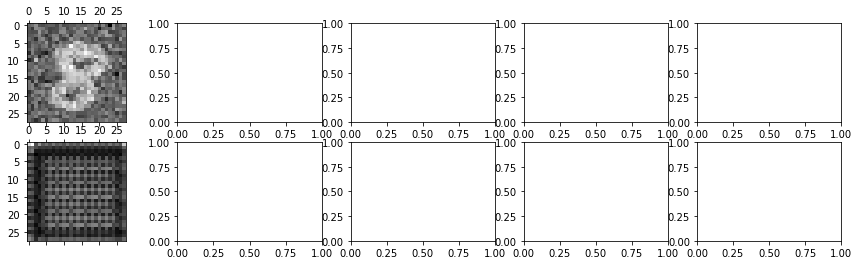

[01/50] cost: 9852.4551
[01/50] cost: 9603.4209
[01/50] cost: 9402.7051
[01/50] cost: 9310.3574
[01/50] cost: 9815.6777
[01/50] cost: 9668.0361
[01/50] cost: 9735.9316
[01/50] cost: 9907.8438
[01/50] cost: 9741.5801
[01/50] cost: 9483.5957
[01/50] cost: 9708.3418
[01/50] cost: 9608.1973
[01/50] cost: 9462.0498
[01/50] cost: 9105.0332
[01/50] cost: 9535.3887
[01/50] cost: 9814.4092
[01/50] cost: 9734.1348
[01/50] cost: 9309.0215
[01/50] cost: 8890.0234
[01/50] cost: 9542.7754
[01/50] cost: 9158.5586
[01/50] cost: 9223.8066
[01/50] cost: 9469.9844
[01/50] cost: 9656.4248
[01/50] cost: 8698.9795
[01/50] cost: 9586.2852
[01/50] cost: 9396.2168
[01/50] cost: 9439.8691
[01/50] cost: 9496.7402
[01/50] cost: 9788.0918
[01/50] cost: 9421.5820
[01/50] cost: 9551.3926
[01/50] cost: 9312.9062
[01/50] cost: 9056.0137
[01/50] cost: 9509.2549
[01/50] cost: 10028.0176
[01/50] cost: 9867.4785
[01/50] cost: 9390.7900
[01/50] cost: 9163.5176
[01/50] cost: 9380.3633
[01/50] cost: 8683.2891
[01/50] cost: 9

[01/50] cost: 7107.4463
[01/50] cost: 6525.4854
[01/50] cost: 6825.8301
[01/50] cost: 6954.7598
[01/50] cost: 6513.3525
[01/50] cost: 6710.1992
[01/50] cost: 6486.0996
[01/50] cost: 6304.3945
[01/50] cost: 6639.5444
[01/50] cost: 6961.6069
[01/50] cost: 6450.1279
[01/50] cost: 6583.8105
[01/50] cost: 6523.1489
[01/50] cost: 6647.9170
[01/50] cost: 6378.0791
[01/50] cost: 6454.4512
[01/50] cost: 6339.9556
[01/50] cost: 6639.6006
[01/50] cost: 6715.7852
[01/50] cost: 6723.7588
[01/50] cost: 6648.1689
[01/50] cost: 6161.2520
[01/50] cost: 6453.5093
[01/50] cost: 6284.7490
[01/50] cost: 6634.6475
[01/50] cost: 6355.8779
[01/50] cost: 6204.5825
[01/50] cost: 6380.9185
[01/50] cost: 6397.1367
[01/50] cost: 6151.0361
[01/50] cost: 6185.6328
[01/50] cost: 6294.3101
[01/50] cost: 6530.2573
[01/50] cost: 6388.4985
[01/50] cost: 5868.2939
[01/50] cost: 6381.8921
[01/50] cost: 6193.2080
[01/50] cost: 6208.6733
[01/50] cost: 5859.7246
[01/50] cost: 6097.5806
[01/50] cost: 6262.7495
[01/50] cost: 60

[02/50] cost: 3666.2861
[02/50] cost: 3787.4856
[02/50] cost: 3747.2871
[02/50] cost: 3874.6118
[02/50] cost: 3704.5625
[02/50] cost: 3789.5642
[02/50] cost: 3621.2944
[02/50] cost: 3545.0654
[02/50] cost: 3731.5142
[02/50] cost: 3689.3066
[02/50] cost: 3727.6812
[02/50] cost: 3552.6260
[02/50] cost: 3659.3691
[02/50] cost: 3468.4263
[02/50] cost: 3641.3877
[02/50] cost: 3534.2043
[02/50] cost: 3456.9253
[02/50] cost: 3711.1519
[02/50] cost: 3605.1968
[02/50] cost: 3581.8555
[02/50] cost: 3661.4951
[02/50] cost: 3496.7554
[02/50] cost: 3660.8862
[02/50] cost: 3412.5703
[02/50] cost: 3607.5173
[02/50] cost: 3564.3135
[02/50] cost: 3637.3008
[02/50] cost: 3571.6792
[02/50] cost: 3630.8740
[02/50] cost: 3762.2070
[02/50] cost: 3690.6091
[02/50] cost: 3531.1313
[02/50] cost: 3497.1138
[02/50] cost: 3544.5918
[02/50] cost: 3642.8936
[02/50] cost: 3480.0229
[02/50] cost: 3792.9116
[02/50] cost: 3633.8447
[02/50] cost: 3583.0386
[02/50] cost: 3769.4951
[02/50] cost: 3591.9241
[02/50] cost: 36

[03/50] cost: 2880.2898
[03/50] cost: 2951.1875
[03/50] cost: 3018.7651
[03/50] cost: 2902.4707
[03/50] cost: 2845.4248
[03/50] cost: 2772.2959
[03/50] cost: 3032.9087
[03/50] cost: 2933.1147
[03/50] cost: 3070.9744
[03/50] cost: 2814.2046
[03/50] cost: 2942.9702
[03/50] cost: 2820.9275
[03/50] cost: 2856.8616
[03/50] cost: 2887.5769
[03/50] cost: 2844.7361
[03/50] cost: 2781.9353
[03/50] cost: 3075.8760
[03/50] cost: 3002.1707
[03/50] cost: 2917.3379
[03/50] cost: 2789.4238
[03/50] cost: 2914.4712
[03/50] cost: 2992.3247
[03/50] cost: 2977.5610
[03/50] cost: 2823.7739
[03/50] cost: 2831.7983
[03/50] cost: 3031.2319
[03/50] cost: 2854.4888
[03/50] cost: 3054.2134
[03/50] cost: 2940.4019
[03/50] cost: 2941.7441
[03/50] cost: 2701.2278
[03/50] cost: 2857.1460
[03/50] cost: 2873.2017
[03/50] cost: 2843.2009
[03/50] cost: 2871.2705
[03/50] cost: 2911.4458
[03/50] cost: 2795.9424
[03/50] cost: 2894.2219
[03/50] cost: 2938.7266
[03/50] cost: 2812.4429
[03/50] cost: 2894.3320
[03/50] cost: 27

[04/50] cost: 2654.2788
[04/50] cost: 2770.6147
[04/50] cost: 2620.8577
[04/50] cost: 2675.6978
[04/50] cost: 2499.6553
[04/50] cost: 2636.3372
[04/50] cost: 2519.5962
[04/50] cost: 2651.8892
[04/50] cost: 2631.1611
[04/50] cost: 2586.0984
[04/50] cost: 2622.2017
[04/50] cost: 2585.4963
[04/50] cost: 2518.3384
[04/50] cost: 2638.5610
[04/50] cost: 2623.7280
[04/50] cost: 2671.1580
[04/50] cost: 2657.0417
[04/50] cost: 2665.2942
[04/50] cost: 2649.3789
[04/50] cost: 2609.9800
[04/50] cost: 2564.3601
[04/50] cost: 2542.0718
[04/50] cost: 2609.7671
[04/50] cost: 2629.4038
[04/50] cost: 2681.6572
[04/50] cost: 2627.4316
[04/50] cost: 2593.9575
[04/50] cost: 2482.4604
[04/50] cost: 2584.1758
[04/50] cost: 2673.0503
[04/50] cost: 2586.2300
[04/50] cost: 2600.7412
[04/50] cost: 2707.9473
[04/50] cost: 2640.5251
[04/50] cost: 2520.9204
[04/50] cost: 2540.9082
[04/50] cost: 2588.5127
[04/50] cost: 2613.6648
[04/50] cost: 2625.9287
[04/50] cost: 2506.6152
[04/50] cost: 2684.9888
[04/50] cost: 26

[05/50] cost: 2431.5820
[05/50] cost: 2521.6870
[05/50] cost: 2530.6716
[05/50] cost: 2498.1770
[05/50] cost: 2416.4692
[05/50] cost: 2544.8018
[05/50] cost: 2545.2815
[05/50] cost: 2380.0327
[05/50] cost: 2362.5139
[05/50] cost: 2321.4055
[05/50] cost: 2412.8025
[05/50] cost: 2382.7004
[05/50] cost: 2470.8562
[05/50] cost: 2675.0874
[05/50] cost: 2568.3750
[05/50] cost: 2453.5667
[05/50] cost: 2375.5596
[05/50] cost: 2431.6487
[05/50] cost: 2352.2300
[05/50] cost: 2435.4600
[05/50] cost: 2421.9016
[05/50] cost: 2457.6677
[05/50] cost: 2550.5759
[05/50] cost: 2363.8667
[05/50] cost: 2565.0366
[05/50] cost: 2482.3999
[05/50] cost: 2515.3240
[05/50] cost: 2330.5342
[05/50] cost: 2369.0410
[05/50] cost: 2447.0132
[05/50] cost: 2447.3918
[05/50] cost: 2336.1934
[05/50] cost: 2404.1445
[05/50] cost: 2424.4558
[05/50] cost: 2437.3928
[05/50] cost: 2462.4336
[05/50] cost: 2462.6313
[05/50] cost: 2360.0044
[05/50] cost: 2397.0435
[05/50] cost: 2237.3398
[05/50] cost: 2364.8462
[05/50] cost: 23

[05/50] cost: 2340.5901
[05/50] cost: 2216.0708
[05/50] cost: 2264.2952
[05/50] cost: 2365.5298
[05/50] cost: 2330.9131
[05/50] cost: 2328.4360
[05/50] cost: 2260.4019
[05/50] cost: 2337.8550
[05/50] cost: 2309.9575
[05/50] cost: 2361.5195
[05/50] cost: 2394.3982
[05/50] cost: 2361.9099
[05/50] cost: 2227.5278
[05/50] cost: 2289.4800
[05/50] cost: 2355.9529
[05/50] cost: 2323.1802
[05/50] cost: 2380.4207
[05/50] cost: 2393.4309
[05/50] cost: 2283.0298
[05/50] cost: 2467.3977
[05/50] cost: 2278.7188
[05/50] cost: 2259.7058
[05/50] cost: 2394.7412
[05/50] cost: 2349.0039
[05/50] cost: 2328.3799
[05/50] cost: 2315.8721
[05/50] cost: 2143.4805
[05/50] cost: 2291.8203
[05/50] cost: 2401.0986
[05/50] cost: 2476.8425
[05/50] cost: 2327.4048
[05/50] cost: 2419.8035
[05/50] cost: 2515.1877
[05/50] cost: 2333.7856
[05/50] cost: 2290.0222
[05/50] cost: 2350.8921
[05/50] cost: 2302.7144
[05/50] cost: 2324.1553
[05/50] cost: 2338.7454
[05/50] cost: 2270.4224
[05/50] cost: 2188.3320
[05/50] cost: 22

[06/50] cost: 2229.4524
[06/50] cost: 2281.8232
[06/50] cost: 2262.8323
[06/50] cost: 2325.5439
[06/50] cost: 2308.3628
[06/50] cost: 2240.1860
[06/50] cost: 2370.7764
[06/50] cost: 2082.4648
[06/50] cost: 2183.3130
[06/50] cost: 2283.0146
[06/50] cost: 2174.3171
[06/50] cost: 2217.5537
[06/50] cost: 2333.4072
[06/50] cost: 2372.8899
[06/50] cost: 2214.8247
[06/50] cost: 2284.1738
[06/50] cost: 2286.8613
[06/50] cost: 2270.1890
[06/50] cost: 2367.0486
[06/50] cost: 2183.1860
[06/50] cost: 2137.6355
[06/50] cost: 2153.2935
[06/50] cost: 2209.2141
[06/50] cost: 2201.4336
[06/50] cost: 2264.9702
[06/50] cost: 2243.6621
[06/50] cost: 2212.0469
[06/50] cost: 2263.1519
[06/50] cost: 2300.4927
[06/50] cost: 2212.3232
[06/50] cost: 2221.0420
[06/50] cost: 2220.8809
[06/50] cost: 2200.2622
[06/50] cost: 2206.4233
[06/50] cost: 2196.3403
[06/50] cost: 2308.2188
[06/50] cost: 2143.7087
[06/50] cost: 2235.3296
[06/50] cost: 2271.8799
[06/50] cost: 2307.1841
[06/50] cost: 2178.9480
[06/50] cost: 23

[07/50] cost: 2116.3999
[07/50] cost: 2279.3530
[07/50] cost: 2204.5002
[07/50] cost: 2152.8645
[07/50] cost: 2250.9917
[07/50] cost: 2110.9956
[07/50] cost: 2192.4971
[07/50] cost: 2160.9438
[07/50] cost: 2127.5215
[07/50] cost: 2102.9236
[07/50] cost: 2160.7617
[07/50] cost: 2124.4917
[07/50] cost: 2202.8638
[07/50] cost: 2156.2554
[07/50] cost: 2201.8159
[07/50] cost: 2209.5308
[07/50] cost: 2200.3770
[07/50] cost: 2307.4507
[07/50] cost: 2160.2051
[07/50] cost: 2147.5593
[07/50] cost: 2118.6895
[07/50] cost: 2077.1230
[07/50] cost: 2197.7395
[07/50] cost: 2183.3787
[07/50] cost: 2101.0835
[07/50] cost: 2203.9683
[07/50] cost: 2254.4629
[07/50] cost: 2138.0732
[07/50] cost: 2215.2305
[07/50] cost: 2109.1768
[07/50] cost: 2235.0664
[07/50] cost: 2125.5786
[07/50] cost: 2089.3779
[07/50] cost: 2211.2122
[07/50] cost: 2166.5459
[07/50] cost: 2140.9688
[07/50] cost: 2076.8796
[07/50] cost: 2243.6343
[07/50] cost: 2102.3665
[07/50] cost: 2245.3066
[07/50] cost: 2120.2603
[07/50] cost: 20

[08/50] cost: 2206.5259
[08/50] cost: 2144.7759
[08/50] cost: 2070.9585
[08/50] cost: 2070.0059
[08/50] cost: 2141.9688
[08/50] cost: 2049.8616
[08/50] cost: 2091.9414
[08/50] cost: 2186.7168
[08/50] cost: 2155.0166
[08/50] cost: 2027.8234
[08/50] cost: 2007.4003
[08/50] cost: 2047.6370
[08/50] cost: 2162.6926
[08/50] cost: 2007.7627
[08/50] cost: 2086.9268
[08/50] cost: 2163.9346
[08/50] cost: 2098.7864
[08/50] cost: 2011.9766
[08/50] cost: 2158.5239
[08/50] cost: 2111.9238
[08/50] cost: 2184.3684
[08/50] cost: 2061.7471
[08/50] cost: 2118.8350
[08/50] cost: 2147.1509
[08/50] cost: 2208.3301
[08/50] cost: 2083.0144
[08/50] cost: 2159.6553
[08/50] cost: 2101.5200
[08/50] cost: 2001.2402
[08/50] cost: 2213.8894
[08/50] cost: 2033.5980
[08/50] cost: 2076.8000
[08/50] cost: 2141.3657
[08/50] cost: 2135.5776
[08/50] cost: 2104.9045
[08/50] cost: 2051.6975
[08/50] cost: 2235.3867
[08/50] cost: 2155.9136
[08/50] cost: 2044.8302
[08/50] cost: 2094.6587
[08/50] cost: 2178.2925
[08/50] cost: 21

[09/50] cost: 2026.6777
[09/50] cost: 2064.5015
[09/50] cost: 1983.1667
[09/50] cost: 2007.8582
[09/50] cost: 2016.2004
[09/50] cost: 2134.3796
[09/50] cost: 2052.9299
[09/50] cost: 2105.2922
[09/50] cost: 2117.6895
[09/50] cost: 2154.9849
[09/50] cost: 2164.5962
[09/50] cost: 2014.5356
[09/50] cost: 2097.6064
[09/50] cost: 2025.7812
[09/50] cost: 2003.1041
[09/50] cost: 2008.7454
[09/50] cost: 2227.6978
[09/50] cost: 2000.9131
[09/50] cost: 2084.7944
[09/50] cost: 1963.1738
[09/50] cost: 2050.9976
[09/50] cost: 2198.4927
[09/50] cost: 2164.7910
[09/50] cost: 1988.6685
[09/50] cost: 2049.5295
[09/50] cost: 2123.0156
[09/50] cost: 2036.4216
[09/50] cost: 1979.9744
[09/50] cost: 2100.1377
[09/50] cost: 2067.3955
[09/50] cost: 2129.0557
[09/50] cost: 2069.6382
[09/50] cost: 2125.4141
[09/50] cost: 2053.9861
[09/50] cost: 1971.5820
[09/50] cost: 2056.7346
[09/50] cost: 2034.6157
[09/50] cost: 2060.7031
[09/50] cost: 2039.7583
[09/50] cost: 2012.8064
[09/50] cost: 1932.2036
[09/50] cost: 21

[09/50] cost: 2013.8290
[09/50] cost: 2034.1343
[09/50] cost: 2151.5801
[09/50] cost: 1998.3367
[09/50] cost: 2071.5505
[09/50] cost: 2129.5864
[09/50] cost: 2145.2598
[09/50] cost: 2171.5767
[09/50] cost: 2088.1704
[09/50] cost: 2041.2488
[09/50] cost: 2097.8926
[09/50] cost: 1889.3247
[09/50] cost: 2002.4919
[09/50] cost: 2099.3113
[09/50] cost: 1920.7479
[09/50] cost: 2083.7427
[09/50] cost: 2178.0493
[09/50] cost: 2141.9214
[09/50] cost: 2180.5498
[09/50] cost: 2095.1235
[09/50] cost: 2045.4111
[09/50] cost: 2061.0305
[09/50] cost: 1956.8281
[09/50] cost: 1955.7820
[09/50] cost: 1846.5571
[09/50] cost: 2078.1565
[09/50] cost: 2115.3237
[09/50] cost: 2027.2017
[09/50] cost: 2110.4561
[09/50] cost: 2127.0588
[09/50] cost: 2087.2566
[09/50] cost: 2089.1279
[09/50] cost: 2026.0496
[09/50] cost: 1983.9679
[09/50] cost: 2041.1252
[09/50] cost: 2050.3608
[09/50] cost: 2024.8363
[09/50] cost: 1945.0137
[09/50] cost: 2088.4771
[09/50] cost: 2087.3027
[09/50] cost: 2116.2896
[09/50] cost: 21

[10/50] cost: 2069.4993
[10/50] cost: 2038.5432
[10/50] cost: 2050.3320
[10/50] cost: 2000.7714
[10/50] cost: 2020.4681
[10/50] cost: 1978.9219
[10/50] cost: 1916.3752
[10/50] cost: 1923.4659
[10/50] cost: 1924.0771
[10/50] cost: 1987.6483
[10/50] cost: 1980.2096
[10/50] cost: 1951.3140
[10/50] cost: 1969.5881
[10/50] cost: 1984.4641
[10/50] cost: 2008.3955
[10/50] cost: 2042.3049
[10/50] cost: 2083.9668
[10/50] cost: 1888.1882
[10/50] cost: 2023.8701
[10/50] cost: 2083.1255
[10/50] cost: 1988.0221
[10/50] cost: 1993.3849
[10/50] cost: 1898.9539
[10/50] cost: 1996.3368
[10/50] cost: 2156.3662
[10/50] cost: 1990.2756
[10/50] cost: 2038.6974
[10/50] cost: 2126.3884
[10/50] cost: 2069.7988
[10/50] cost: 2015.7549
[10/50] cost: 2066.2153
[10/50] cost: 1956.0135
[10/50] cost: 1990.4061
[10/50] cost: 1875.7620
[10/50] cost: 2068.8579
[10/50] cost: 2003.2520
[10/50] cost: 1903.8141
[10/50] cost: 1978.3945
[10/50] cost: 2021.1906
[10/50] cost: 2038.8383
[10/50] cost: 1990.5934
[10/50] cost: 19

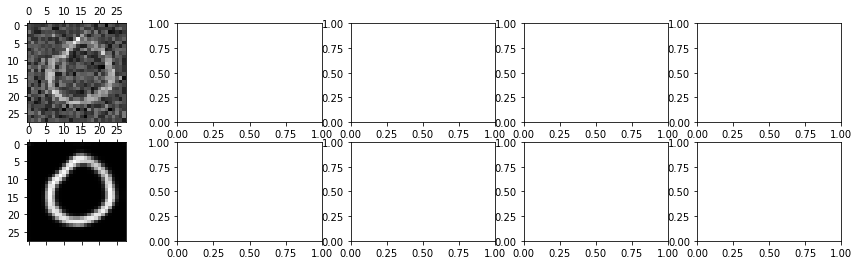

[11/50] cost: 1955.6536
[11/50] cost: 1995.8105
[11/50] cost: 1918.0354
[11/50] cost: 2059.6545
[11/50] cost: 2042.9911
[11/50] cost: 1993.0664
[11/50] cost: 2038.6836
[11/50] cost: 2059.7124
[11/50] cost: 1935.4425
[11/50] cost: 2116.9070
[11/50] cost: 1989.6077
[11/50] cost: 1997.3972
[11/50] cost: 1984.6454
[11/50] cost: 1910.8792
[11/50] cost: 1952.8757
[11/50] cost: 2037.5930
[11/50] cost: 2025.3933
[11/50] cost: 2119.5059
[11/50] cost: 1985.8749
[11/50] cost: 2090.6348
[11/50] cost: 1994.9669
[11/50] cost: 1941.9812
[11/50] cost: 1986.7711
[11/50] cost: 1991.4052
[11/50] cost: 2012.9346
[11/50] cost: 2018.5957
[11/50] cost: 2161.0615
[11/50] cost: 1955.9478
[11/50] cost: 2032.5078
[11/50] cost: 2022.0521
[11/50] cost: 1977.2932
[11/50] cost: 1981.0518
[11/50] cost: 2065.2246
[11/50] cost: 1960.9116
[11/50] cost: 1984.3123
[11/50] cost: 1923.1354
[11/50] cost: 2000.0573
[11/50] cost: 1931.9030
[11/50] cost: 1985.6296
[11/50] cost: 1997.4757
[11/50] cost: 2020.4126
[11/50] cost: 19

[11/50] cost: 2013.6689
[11/50] cost: 2005.0690
[11/50] cost: 2039.9905
[11/50] cost: 1940.4818
[11/50] cost: 1901.6815
[11/50] cost: 2061.3809
[11/50] cost: 2052.5439
[11/50] cost: 2051.0740
[11/50] cost: 1969.7225
[11/50] cost: 1939.4492
[11/50] cost: 1907.7163
[11/50] cost: 2012.9465
[11/50] cost: 1926.9204
[11/50] cost: 2033.8667
[11/50] cost: 1912.7527
[11/50] cost: 2062.0796
[11/50] cost: 1997.8892
[11/50] cost: 2045.0127
[11/50] cost: 1905.5200
[11/50] cost: 1966.9182
[11/50] cost: 1958.9714
[11/50] cost: 1920.3013
[11/50] cost: 1977.9758
[11/50] cost: 1957.8796
[11/50] cost: 1910.8053
[11/50] cost: 2066.7024
[11/50] cost: 1916.7312
[11/50] cost: 2038.7727
[11/50] cost: 2003.3033
[11/50] cost: 2036.8208
[11/50] cost: 1894.1077
[11/50] cost: 1904.0031
[11/50] cost: 1952.6306
[11/50] cost: 1838.8000
[11/50] cost: 2092.7964
[11/50] cost: 1948.2802
[11/50] cost: 1991.2969
[11/50] cost: 2010.6050
[11/50] cost: 2057.2700
[11/50] cost: 1923.5383
[11/50] cost: 1905.1145
[11/50] cost: 19

[12/50] cost: 1901.6680
[12/50] cost: 1880.6562
[12/50] cost: 1951.1755
[12/50] cost: 1985.4111
[12/50] cost: 1931.9918
[12/50] cost: 1928.4028
[12/50] cost: 2001.7858
[12/50] cost: 2031.2036
[12/50] cost: 2050.3423
[12/50] cost: 1960.5577
[12/50] cost: 1925.5586
[12/50] cost: 1953.9009
[12/50] cost: 1886.8895
[12/50] cost: 1881.9819
[12/50] cost: 1873.0461
[12/50] cost: 1957.8191
[12/50] cost: 2026.8936
[12/50] cost: 2006.0557
[12/50] cost: 1972.7761
[12/50] cost: 1948.2186
[12/50] cost: 1905.4565
[12/50] cost: 2007.3838
[12/50] cost: 1936.9539
[12/50] cost: 1951.0386
[12/50] cost: 1992.6230
[12/50] cost: 2002.5029
[12/50] cost: 1965.8879
[12/50] cost: 2093.6353
[12/50] cost: 1881.3118
[12/50] cost: 1969.6775
[12/50] cost: 1915.3746
[12/50] cost: 2045.0583
[12/50] cost: 1882.3237
[12/50] cost: 1859.3285
[12/50] cost: 1982.6514
[12/50] cost: 1995.9141
[12/50] cost: 2051.0925
[12/50] cost: 2009.9526
[12/50] cost: 1931.0081
[12/50] cost: 1964.7957
[12/50] cost: 2046.0573
[12/50] cost: 20

[13/50] cost: 2019.1831
[13/50] cost: 2031.2585
[13/50] cost: 1955.8130
[13/50] cost: 1941.0143
[13/50] cost: 1894.3278
[13/50] cost: 1950.3499
[13/50] cost: 1897.1313
[13/50] cost: 1928.7579
[13/50] cost: 2003.8538
[13/50] cost: 2063.1709
[13/50] cost: 1940.9448
[13/50] cost: 1906.2115
[13/50] cost: 2007.4338
[13/50] cost: 1905.8976
[13/50] cost: 1867.5554
[13/50] cost: 1855.9829
[13/50] cost: 1854.4279
[13/50] cost: 1870.8978
[13/50] cost: 1881.7422
[13/50] cost: 2042.6505
[13/50] cost: 1952.4048
[13/50] cost: 1894.1095
[13/50] cost: 2000.9211
[13/50] cost: 2015.2378
[13/50] cost: 2007.6750
[13/50] cost: 1920.9802
[13/50] cost: 1946.5847
[13/50] cost: 1940.4545
[13/50] cost: 1993.1378
[13/50] cost: 1944.5770
[13/50] cost: 2023.1422
[13/50] cost: 1910.5537
[13/50] cost: 1775.7000
[13/50] cost: 1869.1702
[13/50] cost: 1929.1050
[13/50] cost: 1901.0967
[13/50] cost: 2001.1763
[13/50] cost: 1920.5560
[13/50] cost: 1932.6650
[13/50] cost: 1933.7451
[13/50] cost: 1886.0973
[13/50] cost: 19

[14/50] cost: 1867.5293
[14/50] cost: 1912.5845
[14/50] cost: 1868.0576
[14/50] cost: 1947.0151
[14/50] cost: 1905.6475
[14/50] cost: 1951.5828
[14/50] cost: 1896.7196
[14/50] cost: 1929.0448
[14/50] cost: 1946.2449
[14/50] cost: 1966.5901
[14/50] cost: 1926.7218
[14/50] cost: 1943.1715
[14/50] cost: 1912.5083
[14/50] cost: 1871.7791
[14/50] cost: 1864.4725
[14/50] cost: 1843.0249
[14/50] cost: 1830.8604
[14/50] cost: 1999.6852
[14/50] cost: 1948.1912
[14/50] cost: 1916.5579
[14/50] cost: 1876.6682
[14/50] cost: 1991.4060
[14/50] cost: 1931.5708
[14/50] cost: 2043.8516
[14/50] cost: 1937.9762
[14/50] cost: 1883.3014
[14/50] cost: 1843.1090
[14/50] cost: 1857.5437
[14/50] cost: 1889.2207
[14/50] cost: 1917.3101
[14/50] cost: 1965.7551
[14/50] cost: 2035.2090
[14/50] cost: 1948.3678
[14/50] cost: 1964.5984
[14/50] cost: 1912.7820
[14/50] cost: 1951.1301
[14/50] cost: 1985.4778
[14/50] cost: 1850.4763
[14/50] cost: 1867.1897
[14/50] cost: 1790.1060
[14/50] cost: 1889.9369
[14/50] cost: 19

[15/50] cost: 2009.0615
[15/50] cost: 1834.0459
[15/50] cost: 1897.1860
[15/50] cost: 1784.6299
[15/50] cost: 1981.9871
[15/50] cost: 1830.9639
[15/50] cost: 1793.4004
[15/50] cost: 1903.1327
[15/50] cost: 2072.4541
[15/50] cost: 1804.2805
[15/50] cost: 1900.0077
[15/50] cost: 1930.1316
[15/50] cost: 1964.7880
[15/50] cost: 2010.1982
[15/50] cost: 1888.4427
[15/50] cost: 1756.0686
[15/50] cost: 1902.9802
[15/50] cost: 1788.5232
[15/50] cost: 1855.9922
[15/50] cost: 1970.6794
[15/50] cost: 1930.9771
[15/50] cost: 1883.1652
[15/50] cost: 1939.3085
[15/50] cost: 1840.4447
[15/50] cost: 1914.8112
[15/50] cost: 2003.8949
[15/50] cost: 1823.0735
[15/50] cost: 1942.9023
[15/50] cost: 1796.0356
[15/50] cost: 1911.9883
[15/50] cost: 1871.4904
[15/50] cost: 1851.5862
[15/50] cost: 1956.1447
[15/50] cost: 1923.0472
[15/50] cost: 1997.1724
[15/50] cost: 1928.0293
[15/50] cost: 1934.6150
[15/50] cost: 1964.9753
[15/50] cost: 1867.9673
[15/50] cost: 1931.8500
[15/50] cost: 1900.6008
[15/50] cost: 18

[15/50] cost: 1889.7354
[15/50] cost: 1930.1105
[15/50] cost: 1976.0084
[15/50] cost: 1957.1287
[15/50] cost: 1854.4199
[15/50] cost: 1808.3904
[15/50] cost: 1878.9307
[15/50] cost: 1951.8484
[15/50] cost: 1859.7094
[15/50] cost: 1855.3961
[15/50] cost: 1969.2151
[15/50] cost: 1936.7723
[15/50] cost: 1797.8191
[15/50] cost: 1850.2839
[15/50] cost: 1818.9868
[15/50] cost: 1880.0317
[15/50] cost: 1865.1707
[15/50] cost: 1829.2162
[15/50] cost: 1974.3738
[15/50] cost: 1894.8252
[15/50] cost: 1922.9661
[15/50] cost: 1917.1359
[15/50] cost: 1796.9468
[15/50] cost: 1903.8715
[15/50] cost: 1951.0818
[15/50] cost: 1781.7556
[15/50] cost: 1822.8462
[15/50] cost: 1898.8740
[15/50] cost: 1962.8424
[15/50] cost: 1948.1528
[15/50] cost: 1864.7334
[15/50] cost: 1849.1294
[15/50] cost: 1871.7065
[15/50] cost: 1887.0215
[15/50] cost: 1952.0906
[15/50] cost: 1921.1320
[15/50] cost: 1789.4641
[15/50] cost: 2014.1626
[15/50] cost: 1887.8019
[15/50] cost: 1896.3796
[15/50] cost: 1843.0972
[15/50] cost: 19

[16/50] cost: 2051.6001
[16/50] cost: 1902.0156
[16/50] cost: 1777.6252
[16/50] cost: 1784.8812
[16/50] cost: 1917.2112
[16/50] cost: 1853.0442
[16/50] cost: 1825.0684
[16/50] cost: 1819.1565
[16/50] cost: 1762.5049
[16/50] cost: 1818.7219
[16/50] cost: 1867.5931
[16/50] cost: 1881.3232
[16/50] cost: 1968.2917
[16/50] cost: 1846.8337
[16/50] cost: 1880.6782
[16/50] cost: 1930.0271
[16/50] cost: 1923.9657
[16/50] cost: 1892.3760
[16/50] cost: 1845.2659
[16/50] cost: 1906.5459
[16/50] cost: 1769.7607
[16/50] cost: 1895.5847
[16/50] cost: 1825.8928
[16/50] cost: 1965.1995
[16/50] cost: 1874.3275
[16/50] cost: 1858.7673
[16/50] cost: 1856.1790
[16/50] cost: 1781.0305
[16/50] cost: 1876.2544
[16/50] cost: 1813.2375
[16/50] cost: 1808.9513
[16/50] cost: 1755.0244
[16/50] cost: 1961.9524
[16/50] cost: 1875.2644
[16/50] cost: 1930.3340
[16/50] cost: 1914.2889
[16/50] cost: 1900.6323
[16/50] cost: 1841.5310
[16/50] cost: 1853.5515
[16/50] cost: 1818.2371
[16/50] cost: 1804.2185
[16/50] cost: 17

[17/50] cost: 1810.6455
[17/50] cost: 1859.3746
[17/50] cost: 1808.6283
[17/50] cost: 1878.2023
[17/50] cost: 1786.5043
[17/50] cost: 1881.2528
[17/50] cost: 1890.3328
[17/50] cost: 1906.8446
[17/50] cost: 1917.3979
[17/50] cost: 1785.9805
[17/50] cost: 1863.2527
[17/50] cost: 1828.0428
[17/50] cost: 1841.8704
[17/50] cost: 1882.0332
[17/50] cost: 1926.1912
[17/50] cost: 1825.0972
[17/50] cost: 1939.2952
[17/50] cost: 1892.1001
[17/50] cost: 1836.4768
[17/50] cost: 1893.7715
[17/50] cost: 1840.3604
[17/50] cost: 1817.8132
[17/50] cost: 1725.2273
[17/50] cost: 1865.7258
[17/50] cost: 1887.6963
[17/50] cost: 1875.0266
[17/50] cost: 1868.0999
[17/50] cost: 1905.9723
[17/50] cost: 1834.6267
[17/50] cost: 1926.5608
[17/50] cost: 1883.6898
[17/50] cost: 1795.3145
[17/50] cost: 1919.8054
[17/50] cost: 1873.2407
[17/50] cost: 1769.3894
[17/50] cost: 1860.1121
[17/50] cost: 1787.0518
[17/50] cost: 1788.0432
[17/50] cost: 1887.0571
[17/50] cost: 1882.9419
[17/50] cost: 1903.4069
[17/50] cost: 18

[18/50] cost: 1754.9386
[18/50] cost: 1876.1238
[18/50] cost: 1868.4785
[18/50] cost: 1717.1108
[18/50] cost: 1868.4148
[18/50] cost: 1940.7910
[18/50] cost: 1792.6425
[18/50] cost: 1899.5352
[18/50] cost: 1790.2189
[18/50] cost: 1798.9652
[18/50] cost: 1864.3345
[18/50] cost: 1784.4478
[18/50] cost: 1883.2269
[18/50] cost: 2022.5994
[18/50] cost: 1992.8030
[18/50] cost: 1756.1157
[18/50] cost: 1926.8643
[18/50] cost: 1763.7960
[18/50] cost: 1738.1597
[18/50] cost: 1912.4419
[18/50] cost: 1878.1416
[18/50] cost: 1775.2554
[18/50] cost: 1806.6388
[18/50] cost: 1804.5505
[18/50] cost: 1838.7988
[18/50] cost: 1947.9470
[18/50] cost: 1877.6689
[18/50] cost: 1816.5000
[18/50] cost: 1815.1472
[18/50] cost: 1864.8906
[18/50] cost: 1794.0763
[18/50] cost: 1816.5793
[18/50] cost: 1688.4761
[18/50] cost: 1738.8918
[18/50] cost: 1789.5598
[18/50] cost: 1819.4712
[18/50] cost: 1952.7742
[18/50] cost: 1962.4573
[18/50] cost: 1883.7227
[18/50] cost: 1943.8280
[18/50] cost: 1887.2877
[18/50] cost: 18

[19/50] cost: 1750.0776
[19/50] cost: 1734.0771
[19/50] cost: 1740.6396
[19/50] cost: 1732.8965
[19/50] cost: 1854.3434
[19/50] cost: 1959.3796
[19/50] cost: 1848.8560
[19/50] cost: 1871.4402
[19/50] cost: 1744.6403
[19/50] cost: 1852.4727
[19/50] cost: 1870.9973
[19/50] cost: 1861.8331
[19/50] cost: 1862.0388
[19/50] cost: 1802.0442
[19/50] cost: 1753.4124
[19/50] cost: 1793.9338
[19/50] cost: 1796.5784
[19/50] cost: 1808.0350
[19/50] cost: 1860.5421
[19/50] cost: 1839.5269
[19/50] cost: 1902.9182
[19/50] cost: 1867.9574
[19/50] cost: 1909.9921
[19/50] cost: 1754.8843
[19/50] cost: 1751.4001
[19/50] cost: 1849.2356
[19/50] cost: 1790.8280
[19/50] cost: 1835.5643
[19/50] cost: 1790.7344
[19/50] cost: 1882.9843
[19/50] cost: 1742.8318
[19/50] cost: 1921.6195
[19/50] cost: 1777.0507
[19/50] cost: 1915.1790
[19/50] cost: 1908.3337
[19/50] cost: 1683.1464
[19/50] cost: 1818.7007
[19/50] cost: 1850.4747
[19/50] cost: 1793.6094
[19/50] cost: 1815.8315
[19/50] cost: 1787.9395
[19/50] cost: 18

[19/50] cost: 1896.4055
[19/50] cost: 1837.5251
[19/50] cost: 1729.9463
[19/50] cost: 1852.0410
[19/50] cost: 1792.3004
[19/50] cost: 1839.3101
[19/50] cost: 1800.0422
[19/50] cost: 1754.5051
[19/50] cost: 1850.6899
[19/50] cost: 1823.6431
[19/50] cost: 1869.9369
[19/50] cost: 1750.0272
[19/50] cost: 1754.7781
[19/50] cost: 1731.9568
[19/50] cost: 1778.1565
[19/50] cost: 1852.3512
[19/50] cost: 1813.6953
[19/50] cost: 1724.3727
[19/50] cost: 1815.4923
[19/50] cost: 1801.2975
[19/50] cost: 1862.0988
[19/50] cost: 1838.2618
[19/50] cost: 1894.0134
[19/50] cost: 1832.5941
[19/50] cost: 1838.2891
[19/50] cost: 1799.0956
[19/50] cost: 1719.0551
[19/50] cost: 1812.6555
[19/50] cost: 1852.2605
[19/50] cost: 1874.3489
[19/50] cost: 1894.2415
[19/50] cost: 1927.6398
[19/50] cost: 1746.2266
[19/50] cost: 1758.2561
[19/50] cost: 1831.1971
[19/50] cost: 1681.4480
[19/50] cost: 1760.0920
[19/50] cost: 1732.5624
[19/50] cost: 1951.9374
[19/50] cost: 1843.0894
[19/50] cost: 1822.8429
[19/50] cost: 18

[20/50] cost: 1842.1575
[20/50] cost: 1874.5134
[20/50] cost: 1857.0571
[20/50] cost: 1823.2755
[20/50] cost: 1836.0625
[20/50] cost: 1758.4563
[20/50] cost: 1741.8059
[20/50] cost: 1709.7673
[20/50] cost: 1842.0002
[20/50] cost: 1753.7656
[20/50] cost: 1809.9993
[20/50] cost: 1874.1802
[20/50] cost: 1823.8575
[20/50] cost: 1863.7056
[20/50] cost: 1826.4716
[20/50] cost: 1848.8047
[20/50] cost: 1720.5559
[20/50] cost: 1692.1664
[20/50] cost: 1699.4677
[20/50] cost: 1855.2163
[20/50] cost: 1793.9829
[20/50] cost: 1822.0901
[20/50] cost: 1876.8396
[20/50] cost: 1776.9393
[20/50] cost: 1812.6721
[20/50] cost: 1779.5645
[20/50] cost: 1770.9949
[20/50] cost: 1765.1207
[20/50] cost: 1752.7227
[20/50] cost: 1881.7458
[20/50] cost: 1767.3865
[20/50] cost: 1906.2556
[20/50] cost: 1795.0544
[20/50] cost: 1838.7512
[20/50] cost: 1759.0386
[20/50] cost: 1754.9207
[20/50] cost: 1777.3445
[20/50] cost: 1733.5452
[20/50] cost: 1799.5696
[20/50] cost: 1787.4861
[20/50] cost: 1818.7363
[20/50] cost: 17

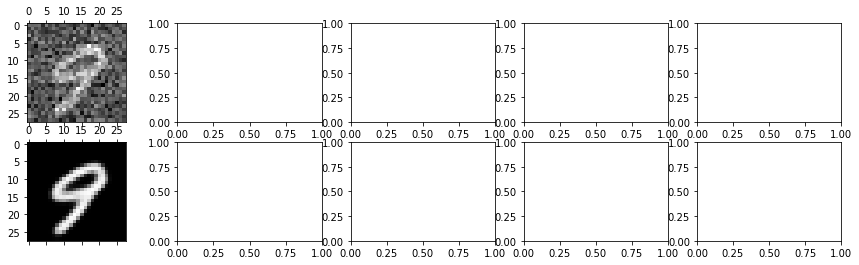

[21/50] cost: 1756.1838
[21/50] cost: 1712.6848
[21/50] cost: 1818.1251
[21/50] cost: 1846.4700
[21/50] cost: 1759.0591
[21/50] cost: 1816.9866
[21/50] cost: 1851.1390
[21/50] cost: 1728.7192
[21/50] cost: 1745.1669
[21/50] cost: 1745.9890
[21/50] cost: 1833.0731
[21/50] cost: 1846.9911
[21/50] cost: 1823.2112
[21/50] cost: 1818.1456
[21/50] cost: 1777.9224
[21/50] cost: 1892.2083
[21/50] cost: 1752.4158
[21/50] cost: 1819.7968
[21/50] cost: 1844.5944
[21/50] cost: 1817.0854
[21/50] cost: 1831.1646
[21/50] cost: 1855.7407
[21/50] cost: 1756.6617
[21/50] cost: 1813.5369
[21/50] cost: 1905.7883
[21/50] cost: 1770.9722
[21/50] cost: 1788.4515
[21/50] cost: 1867.6228
[21/50] cost: 1782.4462
[21/50] cost: 1783.1599
[21/50] cost: 1792.4683
[21/50] cost: 1793.8197
[21/50] cost: 1776.0881
[21/50] cost: 1891.6365
[21/50] cost: 1896.7502
[21/50] cost: 1796.4282
[21/50] cost: 1728.5054
[21/50] cost: 1790.8682
[21/50] cost: 1785.7537
[21/50] cost: 1709.1082
[21/50] cost: 1733.9595
[21/50] cost: 17

[21/50] cost: 1760.7231
[21/50] cost: 1778.0769
[21/50] cost: 1762.6603
[21/50] cost: 1716.5468
[21/50] cost: 1747.3302
[21/50] cost: 1789.7360
[21/50] cost: 1776.6301
[21/50] cost: 1839.5081
[21/50] cost: 1786.6975
[21/50] cost: 1738.6573
[21/50] cost: 1841.3918
[21/50] cost: 1872.2402
[21/50] cost: 1754.0872
[21/50] cost: 1838.0520
[21/50] cost: 1687.9141
[21/50] cost: 1752.4307
[21/50] cost: 1731.5229
[21/50] cost: 1774.6326
[21/50] cost: 1821.2014
[21/50] cost: 1876.5269
[21/50] cost: 1814.9142
[21/50] cost: 1734.3540
[21/50] cost: 1844.9917
[21/50] cost: 1805.8706
[21/50] cost: 1813.4861
[21/50] cost: 1802.1667
[21/50] cost: 1757.5170
[21/50] cost: 1811.6841
[21/50] cost: 1720.3479
[21/50] cost: 1749.2566
[21/50] cost: 1792.2450
[21/50] cost: 1800.1660
[21/50] cost: 1829.0869
[21/50] cost: 1802.3445
[21/50] cost: 1842.4250
[21/50] cost: 1810.6864
[21/50] cost: 1813.6394
[21/50] cost: 1793.5919
[21/50] cost: 1808.7815
[21/50] cost: 1693.9680
[21/50] cost: 1758.6675
[21/50] cost: 17

[22/50] cost: 1754.8053
[22/50] cost: 1820.6667
[22/50] cost: 1774.0439
[22/50] cost: 1818.0869
[22/50] cost: 1831.0444
[22/50] cost: 1779.9111
[22/50] cost: 1837.3752
[22/50] cost: 1727.5002
[22/50] cost: 1735.2017
[22/50] cost: 1731.7709
[22/50] cost: 1738.2327
[22/50] cost: 1805.0474
[22/50] cost: 1755.1968
[22/50] cost: 1828.3508
[22/50] cost: 1803.1880
[22/50] cost: 1807.9633
[22/50] cost: 1688.2339
[22/50] cost: 1750.7657
[22/50] cost: 1640.3062
[22/50] cost: 1731.2910
[22/50] cost: 1742.0022
[22/50] cost: 1752.3577
[22/50] cost: 1807.6378
[22/50] cost: 1798.6802
[22/50] cost: 1847.1466
[22/50] cost: 1857.0958
[22/50] cost: 1854.7571
[22/50] cost: 1882.8569
[22/50] cost: 1747.4771
[22/50] cost: 1808.6431
[22/50] cost: 1716.0950
[22/50] cost: 1709.4600
[22/50] cost: 1781.7400
[22/50] cost: 1837.6562
[22/50] cost: 1861.9904
[22/50] cost: 1840.9478
[22/50] cost: 1858.9380
[22/50] cost: 1854.1572
[22/50] cost: 1807.5430
[22/50] cost: 1818.7070
[22/50] cost: 1732.4147
[22/50] cost: 18

[23/50] cost: 1791.4253
[23/50] cost: 1841.9133
[23/50] cost: 1790.0643
[23/50] cost: 1905.5129
[23/50] cost: 1804.3599
[23/50] cost: 1733.2390
[23/50] cost: 1817.6580
[23/50] cost: 1765.9005
[23/50] cost: 1810.6211
[23/50] cost: 1799.3623
[23/50] cost: 1880.7161
[23/50] cost: 1878.2474
[23/50] cost: 1826.2012
[23/50] cost: 1795.7042
[23/50] cost: 1694.2524
[23/50] cost: 1928.6797
[23/50] cost: 1727.5874
[23/50] cost: 1761.1152
[23/50] cost: 1782.8470
[23/50] cost: 1779.8838
[23/50] cost: 1701.9163
[23/50] cost: 1761.9542
[23/50] cost: 1739.5233
[23/50] cost: 1805.4058
[23/50] cost: 1696.5923
[23/50] cost: 1745.3257
[23/50] cost: 1824.6221
[23/50] cost: 1786.1875
[23/50] cost: 1763.8235
[23/50] cost: 1789.3009
[23/50] cost: 1807.4758
[23/50] cost: 1782.2388
[23/50] cost: 1783.1873
[23/50] cost: 1649.9651
[23/50] cost: 1744.2798
[23/50] cost: 1756.0050
[23/50] cost: 1732.0710
[23/50] cost: 1791.0521
[23/50] cost: 1766.5073
[23/50] cost: 1759.6797
[23/50] cost: 1803.3354
[23/50] cost: 18

[24/50] cost: 1738.2249
[24/50] cost: 1787.5718
[24/50] cost: 1744.6792
[24/50] cost: 1758.1449
[24/50] cost: 1807.5974
[24/50] cost: 1752.7693
[24/50] cost: 1842.6245
[24/50] cost: 1830.4027
[24/50] cost: 1741.5649
[24/50] cost: 1728.1018
[24/50] cost: 1749.3416
[24/50] cost: 1742.4297
[24/50] cost: 1719.9733
[24/50] cost: 1754.1621
[24/50] cost: 1733.2896
[24/50] cost: 1828.1202
[24/50] cost: 1739.8103
[24/50] cost: 1780.0305
[24/50] cost: 1846.3955
[24/50] cost: 1834.2859
[24/50] cost: 1761.6421
[24/50] cost: 1729.5012
[24/50] cost: 1745.9225
[24/50] cost: 1740.7583
[24/50] cost: 1694.4901
[24/50] cost: 1780.5592
[24/50] cost: 1823.2830
[24/50] cost: 1824.2939
[24/50] cost: 1767.8153
[24/50] cost: 1864.7561
[24/50] cost: 1828.7357
[24/50] cost: 1795.7871
[24/50] cost: 1772.5176
[24/50] cost: 1719.6926
[24/50] cost: 1727.1533
[24/50] cost: 1793.0046
[24/50] cost: 1758.8458
[24/50] cost: 1783.0933
[24/50] cost: 1823.3243
[24/50] cost: 1834.6071
[24/50] cost: 1701.0439
[24/50] cost: 17

[25/50] cost: 1765.5708
[25/50] cost: 1687.5095
[25/50] cost: 1807.1990
[25/50] cost: 1659.8792
[25/50] cost: 1725.2883
[25/50] cost: 1808.5446
[25/50] cost: 1896.4543
[25/50] cost: 1728.5581
[25/50] cost: 1839.7360
[25/50] cost: 1820.5775
[25/50] cost: 1798.9496
[25/50] cost: 1697.7471
[25/50] cost: 1788.0298
[25/50] cost: 1718.8644
[25/50] cost: 1699.8815
[25/50] cost: 1748.8499
[25/50] cost: 1881.4205
[25/50] cost: 1760.7986
[25/50] cost: 1810.4412
[25/50] cost: 1798.6211
[25/50] cost: 1875.7974
[25/50] cost: 1815.9033
[25/50] cost: 1752.8728
[25/50] cost: 1792.7926
[25/50] cost: 1671.6075
[25/50] cost: 1707.0475
[25/50] cost: 1742.3074
[25/50] cost: 1691.9639
[25/50] cost: 1728.7042
[25/50] cost: 1858.6497
[25/50] cost: 1819.5509
[25/50] cost: 1837.2703
[25/50] cost: 1806.2249
[25/50] cost: 1792.4156
[25/50] cost: 1680.6492
[25/50] cost: 1728.8920
[25/50] cost: 1730.4131
[25/50] cost: 1697.7625
[25/50] cost: 1763.7678
[25/50] cost: 1704.0452
[25/50] cost: 1815.7612
[25/50] cost: 17

[25/50] cost: 1667.9510
[25/50] cost: 1725.6274
[25/50] cost: 1888.4292
[25/50] cost: 1748.1250
[25/50] cost: 1905.2848
[25/50] cost: 1718.4448
[25/50] cost: 1792.9839
[25/50] cost: 1797.8501
[25/50] cost: 1677.9326
[25/50] cost: 1710.5813
[25/50] cost: 1741.2987
[25/50] cost: 1788.6633
[25/50] cost: 1811.5778
[25/50] cost: 1735.4421
[25/50] cost: 1835.5405
[25/50] cost: 1763.4984
[25/50] cost: 1908.6880
[25/50] cost: 1755.4014
[25/50] cost: 1836.5133
[25/50] cost: 1744.8612
[25/50] cost: 1701.8115
[25/50] cost: 1737.8027
[25/50] cost: 1716.4932
[25/50] cost: 1693.9224
[25/50] cost: 1808.1523
[25/50] cost: 1786.4568
[25/50] cost: 1750.7715
[25/50] cost: 1848.5292
[25/50] cost: 1757.6736
[25/50] cost: 1720.1189
[25/50] cost: 1759.8296
[25/50] cost: 1680.2286
[25/50] cost: 1774.4335
[25/50] cost: 1714.6863
[25/50] cost: 1746.3663
[25/50] cost: 1715.6967
[25/50] cost: 1650.3259
[25/50] cost: 1773.4158
[25/50] cost: 1833.5486
[25/50] cost: 1763.4338
[25/50] cost: 1729.1345
[25/50] cost: 18

[26/50] cost: 1718.2402
[26/50] cost: 1700.8016
[26/50] cost: 1785.1293
[26/50] cost: 1791.9299
[26/50] cost: 1777.8970
[26/50] cost: 1795.0499
[26/50] cost: 1738.2043
[26/50] cost: 1737.6680
[26/50] cost: 1639.2175
[26/50] cost: 1764.8376
[26/50] cost: 1780.5007
[26/50] cost: 1830.6455
[26/50] cost: 1798.1509
[26/50] cost: 1728.3066
[26/50] cost: 1655.8429
[26/50] cost: 1698.3257
[26/50] cost: 1644.7671
[26/50] cost: 1715.2080
[26/50] cost: 1745.3597
[26/50] cost: 1821.8011
[26/50] cost: 1745.7765
[26/50] cost: 1749.9902
[26/50] cost: 1734.1101
[26/50] cost: 1865.2001
[26/50] cost: 1752.2136
[26/50] cost: 1748.4128
[26/50] cost: 1730.8267
[26/50] cost: 1675.8856
[26/50] cost: 1780.5265
[26/50] cost: 1694.0039
[26/50] cost: 1814.8010
[26/50] cost: 1823.9078
[26/50] cost: 1800.2249
[26/50] cost: 1800.7612
[26/50] cost: 1659.3616
[26/50] cost: 1850.3906
[26/50] cost: 1666.3604
[26/50] cost: 1793.8127
[26/50] cost: 1763.0588
[26/50] cost: 1659.1650
[26/50] cost: 1760.8679
[26/50] cost: 17

[27/50] cost: 1816.4705
[27/50] cost: 1821.0043
[27/50] cost: 1755.2126
[27/50] cost: 1734.6074
[27/50] cost: 1812.4819
[27/50] cost: 1774.6154
[27/50] cost: 1704.4504
[27/50] cost: 1763.0712
[27/50] cost: 1776.0200
[27/50] cost: 1765.9673
[27/50] cost: 1714.3279
[27/50] cost: 1655.4333
[27/50] cost: 1720.6682
[27/50] cost: 1767.1305
[27/50] cost: 1710.0598
[27/50] cost: 1737.4552
[27/50] cost: 1807.9619
[27/50] cost: 1651.1353
[27/50] cost: 1764.1324
[27/50] cost: 1770.0465
[27/50] cost: 1719.5596
[27/50] cost: 1721.5039
[27/50] cost: 1708.0312
[27/50] cost: 1735.7341
[27/50] cost: 1727.0881
[27/50] cost: 1832.9364
[27/50] cost: 1779.0295
[27/50] cost: 1797.5669
[27/50] cost: 1775.9244
[27/50] cost: 1741.7466
[27/50] cost: 1690.6450
[27/50] cost: 1689.5188
[27/50] cost: 1671.8276
[27/50] cost: 1743.1581
[27/50] cost: 1785.9934
[27/50] cost: 1713.2473
[27/50] cost: 1782.5825
[27/50] cost: 1786.1836
[27/50] cost: 1721.9763
[27/50] cost: 1663.5171
[27/50] cost: 1742.6842
[27/50] cost: 16

[28/50] cost: 1707.5153
[28/50] cost: 1696.0699
[28/50] cost: 1737.5198
[28/50] cost: 1765.5271
[28/50] cost: 1730.5657
[28/50] cost: 1736.4630
[28/50] cost: 1743.5115
[28/50] cost: 1778.5309
[28/50] cost: 1731.0183
[28/50] cost: 1744.9534
[28/50] cost: 1723.1232
[28/50] cost: 1600.2584
[28/50] cost: 1759.0515
[28/50] cost: 1848.7150
[28/50] cost: 1761.8082
[28/50] cost: 1690.6953
[28/50] cost: 1793.0662
[28/50] cost: 1662.7224
[28/50] cost: 1690.6178
[28/50] cost: 1694.4344
[28/50] cost: 1760.9786
[28/50] cost: 1818.4760
[28/50] cost: 1715.4573
[28/50] cost: 1785.0188
[28/50] cost: 1766.0748
[28/50] cost: 1718.7344
[28/50] cost: 1753.1282
[28/50] cost: 1695.2018
[28/50] cost: 1820.9642
[28/50] cost: 1666.0652
[28/50] cost: 1719.2378
[28/50] cost: 1769.2076
[28/50] cost: 1723.7162
[28/50] cost: 1831.4160
[28/50] cost: 1792.0671
[28/50] cost: 1710.5723
[28/50] cost: 1726.8635
[28/50] cost: 1790.0621
[28/50] cost: 1737.3411
[28/50] cost: 1751.6748
[28/50] cost: 1668.3926
[28/50] cost: 17

[29/50] cost: 1708.8422
[29/50] cost: 1751.4015
[29/50] cost: 1743.9675
[29/50] cost: 1710.9537
[29/50] cost: 1683.1995
[29/50] cost: 1679.1030
[29/50] cost: 1665.6160
[29/50] cost: 1840.7017
[29/50] cost: 1748.1970
[29/50] cost: 1824.2527
[29/50] cost: 1750.8552
[29/50] cost: 1728.8579
[29/50] cost: 1807.6550
[29/50] cost: 1720.1710
[29/50] cost: 1697.2693
[29/50] cost: 1664.7172
[29/50] cost: 1792.3645
[29/50] cost: 1756.6442
[29/50] cost: 1748.0017
[29/50] cost: 1724.7275
[29/50] cost: 1737.3796
[29/50] cost: 1741.3379
[29/50] cost: 1695.5762
[29/50] cost: 1743.3843
[29/50] cost: 1803.3732
[29/50] cost: 1756.5901
[29/50] cost: 1768.4166
[29/50] cost: 1752.3328
[29/50] cost: 1733.1995
[29/50] cost: 1718.6748
[29/50] cost: 1780.3987
[29/50] cost: 1676.6453
[29/50] cost: 1761.5763
[29/50] cost: 1708.6929
[29/50] cost: 1695.2817
[29/50] cost: 1829.8210
[29/50] cost: 1772.0779
[29/50] cost: 1787.0674
[29/50] cost: 1712.4144
[29/50] cost: 1662.6802
[29/50] cost: 1787.1810
[29/50] cost: 16

[29/50] cost: 1783.3120
[29/50] cost: 1743.8645
[29/50] cost: 1780.0869
[29/50] cost: 1821.1333
[29/50] cost: 1718.4600
[29/50] cost: 1697.4414
[29/50] cost: 1736.2593
[29/50] cost: 1734.5522
[29/50] cost: 1727.7590
[29/50] cost: 1781.3290
[29/50] cost: 1760.2601
[29/50] cost: 1691.6112
[29/50] cost: 1655.0903
[29/50] cost: 1705.4904
[29/50] cost: 1812.2817
[29/50] cost: 1766.6941
[29/50] cost: 1790.4432
[29/50] cost: 1884.0137
[29/50] cost: 1634.9972
[29/50] cost: 1744.8701
[29/50] cost: 1669.8254
[29/50] cost: 1679.8225
[29/50] cost: 1706.3981
[29/50] cost: 1697.2535
[29/50] cost: 1735.9695
[29/50] cost: 1930.1565
[29/50] cost: 1776.6207
[29/50] cost: 1805.2690
[29/50] cost: 1773.7832
[29/50] cost: 1737.7964
[29/50] cost: 1708.5773
[29/50] cost: 1745.3918
[29/50] cost: 1687.0819
[29/50] cost: 1772.1283
[29/50] cost: 1712.8539
[29/50] cost: 1700.1539
[29/50] cost: 1681.4373
[29/50] cost: 1680.9502
[29/50] cost: 1741.3162
[29/50] cost: 1786.2617
[29/50] cost: 1796.8708
[29/50] cost: 18

[30/50] cost: 1794.0085
[30/50] cost: 1723.1215
[30/50] cost: 1744.1748
[30/50] cost: 1709.8120
[30/50] cost: 1764.1881
[30/50] cost: 1666.5750
[30/50] cost: 1718.7959
[30/50] cost: 1787.6017
[30/50] cost: 1661.2205
[30/50] cost: 1675.6250
[30/50] cost: 1814.6775
[30/50] cost: 1715.4446
[30/50] cost: 1722.2347
[30/50] cost: 1730.1133
[30/50] cost: 1730.0311
[30/50] cost: 1677.5323
[30/50] cost: 1778.6154
[30/50] cost: 1673.8381
[30/50] cost: 1667.4102
[30/50] cost: 1772.1860
[30/50] cost: 1705.1882
[30/50] cost: 1725.0631
[30/50] cost: 1819.2125
[30/50] cost: 1745.2786
[30/50] cost: 1715.9753
[30/50] cost: 1705.8682
[30/50] cost: 1688.9940
[30/50] cost: 1763.1924
[30/50] cost: 1643.0792
[30/50] cost: 1717.1277
[30/50] cost: 1709.9451
[30/50] cost: 1685.1289
[30/50] cost: 1736.1655
[30/50] cost: 1757.8723
[30/50] cost: 1809.9055
[30/50] cost: 1735.0745
[30/50] cost: 1793.7444
[30/50] cost: 1766.5291
[30/50] cost: 1785.6479
[30/50] cost: 1720.4065
[30/50] cost: 1761.9088
[30/50] cost: 16

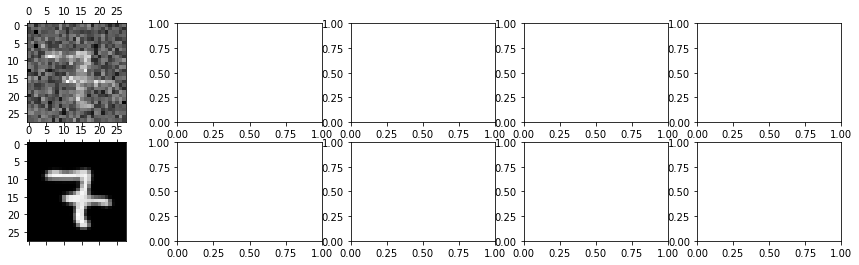

[31/50] cost: 1707.4290
[31/50] cost: 1661.0620
[31/50] cost: 1807.7035
[31/50] cost: 1683.2295
[31/50] cost: 1689.1328
[31/50] cost: 1708.8997
[31/50] cost: 1804.6665
[31/50] cost: 1780.8517
[31/50] cost: 1687.5142
[31/50] cost: 1732.7766
[31/50] cost: 1612.1655
[31/50] cost: 1737.7764
[31/50] cost: 1693.9260
[31/50] cost: 1726.4955
[31/50] cost: 1796.6191
[31/50] cost: 1724.5020
[31/50] cost: 1735.4502
[31/50] cost: 1834.1765
[31/50] cost: 1614.6755
[31/50] cost: 1788.2009
[31/50] cost: 1695.6707
[31/50] cost: 1819.4369
[31/50] cost: 1746.3857
[31/50] cost: 1768.0396
[31/50] cost: 1841.0564
[31/50] cost: 1659.3999
[31/50] cost: 1654.3792
[31/50] cost: 1728.3591
[31/50] cost: 1665.6266
[31/50] cost: 1699.9586
[31/50] cost: 1682.5867
[31/50] cost: 1682.8601
[31/50] cost: 1789.0806
[31/50] cost: 1736.9368
[31/50] cost: 1773.5695
[31/50] cost: 1623.5974
[31/50] cost: 1813.7856
[31/50] cost: 1726.5774
[31/50] cost: 1677.7515
[31/50] cost: 1737.2943
[31/50] cost: 1687.8990
[31/50] cost: 17

[31/50] cost: 1704.6577
[31/50] cost: 1695.6404
[31/50] cost: 1715.6729
[31/50] cost: 1733.3135
[31/50] cost: 1698.7432
[31/50] cost: 1678.5836
[31/50] cost: 1726.4164
[31/50] cost: 1812.0510
[31/50] cost: 1668.9437
[31/50] cost: 1766.6591
[31/50] cost: 1801.0989
[31/50] cost: 1802.5181
[31/50] cost: 1657.2720
[31/50] cost: 1671.5044
[31/50] cost: 1676.8408
[31/50] cost: 1843.2869
[31/50] cost: 1819.3989
[31/50] cost: 1750.4452
[31/50] cost: 1766.8282
[31/50] cost: 1673.2004
[31/50] cost: 1724.1173
[31/50] cost: 1630.7937
[31/50] cost: 1815.5245
[31/50] cost: 1756.0242
[31/50] cost: 1719.6807
[31/50] cost: 1791.5571
[31/50] cost: 1855.7498
[31/50] cost: 1692.3369
[31/50] cost: 1729.6523
[31/50] cost: 1762.3057
[31/50] cost: 1698.1309
[31/50] cost: 1677.5269
[31/50] cost: 1759.4207
[31/50] cost: 1776.8760
[31/50] cost: 1855.2087
[31/50] cost: 1758.3643
[31/50] cost: 1656.6957
[31/50] cost: 1781.2992
[31/50] cost: 1675.7850
[31/50] cost: 1771.6005
[31/50] cost: 1770.8159
[31/50] cost: 16

[32/50] cost: 1667.2517
[32/50] cost: 1802.4670
[32/50] cost: 1671.6064
[32/50] cost: 1733.6296
[32/50] cost: 1691.3870
[32/50] cost: 1635.7023
[32/50] cost: 1729.5562
[32/50] cost: 1705.5990
[32/50] cost: 1701.9083
[32/50] cost: 1696.6760
[32/50] cost: 1677.9644
[32/50] cost: 1749.6208
[32/50] cost: 1726.4280
[32/50] cost: 1698.4106
[32/50] cost: 1647.3596
[32/50] cost: 1633.1653
[32/50] cost: 1708.9224
[32/50] cost: 1743.6490
[32/50] cost: 1693.2798
[32/50] cost: 1832.5874
[32/50] cost: 1676.1276
[32/50] cost: 1683.1160
[32/50] cost: 1741.9663
[32/50] cost: 1587.7014
[32/50] cost: 1730.0398
[32/50] cost: 1728.5530
[32/50] cost: 1686.9124
[32/50] cost: 1738.2064
[32/50] cost: 1734.7126
[32/50] cost: 1685.0442
[32/50] cost: 1743.4453
[32/50] cost: 1696.6522
[32/50] cost: 1700.9097
[32/50] cost: 1821.3921
[32/50] cost: 1671.3354
[32/50] cost: 1706.7898
[32/50] cost: 1712.5021
[32/50] cost: 1713.4531
[32/50] cost: 1757.4192
[32/50] cost: 1772.8115
[32/50] cost: 1735.8110
[32/50] cost: 17

[33/50] cost: 1686.5087
[33/50] cost: 1659.5120
[33/50] cost: 1724.3937
[33/50] cost: 1790.7528
[33/50] cost: 1736.4037
[33/50] cost: 1795.3950
[33/50] cost: 1708.4050
[33/50] cost: 1722.8112
[33/50] cost: 1770.7786
[33/50] cost: 1666.4260
[33/50] cost: 1760.0188
[33/50] cost: 1746.3242
[33/50] cost: 1727.2891
[33/50] cost: 1653.3865
[33/50] cost: 1686.7640
[33/50] cost: 1649.6982
[33/50] cost: 1737.3442
[33/50] cost: 1791.0800
[33/50] cost: 1728.3096
[33/50] cost: 1774.7435
[33/50] cost: 1840.3064
[33/50] cost: 1676.0583
[33/50] cost: 1765.7839
[33/50] cost: 1810.9075
[33/50] cost: 1755.9705
[33/50] cost: 1648.3772
[33/50] cost: 1599.2805
[33/50] cost: 1736.4363
[33/50] cost: 1694.3262
[33/50] cost: 1672.0068
[33/50] cost: 1715.0386
[33/50] cost: 1663.6199
[33/50] cost: 1835.1416
[33/50] cost: 1706.7816
[33/50] cost: 1678.8103
[33/50] cost: 1761.5918
[33/50] cost: 1678.2214
[33/50] cost: 1754.9641
[33/50] cost: 1620.8688
[33/50] cost: 1667.0040
[33/50] cost: 1715.9231
[33/50] cost: 17

[34/50] cost: 1625.6918
[34/50] cost: 1688.6799
[34/50] cost: 1829.9130
[34/50] cost: 1755.2622
[34/50] cost: 1806.8701
[34/50] cost: 1681.8374
[34/50] cost: 1753.5527
[34/50] cost: 1812.3458
[34/50] cost: 1765.1776
[34/50] cost: 1741.9755
[34/50] cost: 1720.5918
[34/50] cost: 1705.5022
[34/50] cost: 1645.0005
[34/50] cost: 1751.7690
[34/50] cost: 1798.0637
[34/50] cost: 1751.5015
[34/50] cost: 1808.6448
[34/50] cost: 1864.9614
[34/50] cost: 1686.7705
[34/50] cost: 1676.9800
[34/50] cost: 1723.5781
[34/50] cost: 1660.8958
[34/50] cost: 1663.4818
[34/50] cost: 1667.9292
[34/50] cost: 1734.0391
[34/50] cost: 1750.2363
[34/50] cost: 1702.8850
[34/50] cost: 1814.9982
[34/50] cost: 1734.6774
[34/50] cost: 1658.4165
[34/50] cost: 1733.9133
[34/50] cost: 1700.9167
[34/50] cost: 1711.0048
[34/50] cost: 1699.2227
[34/50] cost: 1686.2310
[34/50] cost: 1711.7385
[34/50] cost: 1678.9768
[34/50] cost: 1747.1257
[34/50] cost: 1862.9121
[34/50] cost: 1846.4902
[34/50] cost: 1755.9309
[34/50] cost: 18

[35/50] cost: 1675.3761
[35/50] cost: 1704.7932
[35/50] cost: 1723.7662
[35/50] cost: 1678.1655
[35/50] cost: 1745.3539
[35/50] cost: 1713.1230
[35/50] cost: 1644.2046
[35/50] cost: 1740.8999
[35/50] cost: 1724.1177
[35/50] cost: 1663.6239
[35/50] cost: 1800.7073
[35/50] cost: 1774.0742
[35/50] cost: 1713.3525
[35/50] cost: 1685.7732
[35/50] cost: 1747.3146
[35/50] cost: 1649.4722
[35/50] cost: 1659.9397
[35/50] cost: 1726.4468
[35/50] cost: 1793.4768
[35/50] cost: 1757.2787
[35/50] cost: 1740.3868
[35/50] cost: 1729.9275
[35/50] cost: 1700.4836
[35/50] cost: 1798.1936
[35/50] cost: 1707.2219
[35/50] cost: 1652.0168
[35/50] cost: 1663.5308
[35/50] cost: 1720.8892
[35/50] cost: 1767.9788
[35/50] cost: 1755.3325
[35/50] cost: 1696.2966
[35/50] cost: 1663.0498
[35/50] cost: 1748.6815
[35/50] cost: 1698.0742
[35/50] cost: 1707.0541
[35/50] cost: 1712.3773
[35/50] cost: 1780.7510
[35/50] cost: 1666.6375
[35/50] cost: 1738.9753
[35/50] cost: 1614.2747
[35/50] cost: 1656.3484
[35/50] cost: 17

[35/50] cost: 1734.5645
[35/50] cost: 1652.0867
[35/50] cost: 1712.7847
[35/50] cost: 1692.5691
[35/50] cost: 1724.2261
[35/50] cost: 1616.6787
[35/50] cost: 1654.3022
[35/50] cost: 1629.9202
[35/50] cost: 1795.2817
[35/50] cost: 1615.6313
[35/50] cost: 1730.9485
[35/50] cost: 1729.3866
[35/50] cost: 1720.8385
[35/50] cost: 1662.2161
[35/50] cost: 1761.2263
[35/50] cost: 1777.9642
[35/50] cost: 1582.2162
[35/50] cost: 1645.8226
[35/50] cost: 1792.4358
[35/50] cost: 1685.0066
[35/50] cost: 1568.7102
[35/50] cost: 1662.0823
[35/50] cost: 1748.3479
[35/50] cost: 1722.5515
[35/50] cost: 1708.6440
[35/50] cost: 1709.1470
[35/50] cost: 1730.6689
[35/50] cost: 1792.4397
[35/50] cost: 1698.7476
[35/50] cost: 1610.6272
[35/50] cost: 1691.6538
[35/50] cost: 1708.5847
[35/50] cost: 1650.6216
[35/50] cost: 1737.0983
[35/50] cost: 1666.6987
[35/50] cost: 1688.6660
[35/50] cost: 1761.3081
[35/50] cost: 1669.0791
[35/50] cost: 1735.8909
[35/50] cost: 1724.2394
[35/50] cost: 1673.8967
[35/50] cost: 16

[36/50] cost: 1646.7990
[36/50] cost: 1713.0933
[36/50] cost: 1701.5940
[36/50] cost: 1682.3552
[36/50] cost: 1625.7905
[36/50] cost: 1767.9526
[36/50] cost: 1721.7461
[36/50] cost: 1730.5420
[36/50] cost: 1632.0137
[36/50] cost: 1623.4583
[36/50] cost: 1724.7798
[36/50] cost: 1677.0955
[36/50] cost: 1837.6073
[36/50] cost: 1695.9102
[36/50] cost: 1748.6566
[36/50] cost: 1717.1356
[36/50] cost: 1727.9272
[36/50] cost: 1843.8943
[36/50] cost: 1777.2675
[36/50] cost: 1691.5935
[36/50] cost: 1669.9192
[36/50] cost: 1720.2161
[36/50] cost: 1676.8735
[36/50] cost: 1663.7920
[36/50] cost: 1689.8245
[36/50] cost: 1720.7083
[36/50] cost: 1763.8878
[36/50] cost: 1673.6771
[36/50] cost: 1713.7405
[36/50] cost: 1680.7844
[36/50] cost: 1757.2949
[36/50] cost: 1644.0020
[36/50] cost: 1711.0209
[36/50] cost: 1807.6296
[36/50] cost: 1699.3284
[36/50] cost: 1701.2733
[36/50] cost: 1841.3521
[36/50] cost: 1688.8171
[36/50] cost: 1732.1379
[36/50] cost: 1631.7280
[36/50] cost: 1767.5680
[36/50] cost: 16

[37/50] cost: 1726.5535
[37/50] cost: 1700.5344
[37/50] cost: 1764.8174
[37/50] cost: 1770.1187
[37/50] cost: 1771.3724
[37/50] cost: 1805.0927
[37/50] cost: 1648.4387
[37/50] cost: 1764.3175
[37/50] cost: 1647.0608
[37/50] cost: 1794.1282
[37/50] cost: 1617.7898
[37/50] cost: 1658.8463
[37/50] cost: 1745.5066
[37/50] cost: 1754.3965
[37/50] cost: 1688.6788
[37/50] cost: 1734.6663
[37/50] cost: 1646.8447
[37/50] cost: 1609.0925
[37/50] cost: 1804.8977
[37/50] cost: 1644.5985
[37/50] cost: 1675.3550
[37/50] cost: 1797.2943
[37/50] cost: 1624.7185
[37/50] cost: 1815.4150
[37/50] cost: 1674.3248
[37/50] cost: 1827.0472
[37/50] cost: 1697.1146
[37/50] cost: 1591.8093
[37/50] cost: 1694.5555
[37/50] cost: 1761.2959
[37/50] cost: 1738.2847
[37/50] cost: 1807.2739
[37/50] cost: 1768.6929
[37/50] cost: 1737.2188
[37/50] cost: 1794.3615
[37/50] cost: 1736.2490
[37/50] cost: 1623.8807
[37/50] cost: 1660.0726
[37/50] cost: 1704.1304
[37/50] cost: 1708.2229
[37/50] cost: 1644.6125
[37/50] cost: 17

[38/50] cost: 1702.4320
[38/50] cost: 1660.5576
[38/50] cost: 1673.5569
[38/50] cost: 1788.6995
[38/50] cost: 1745.3335
[38/50] cost: 1743.6443
[38/50] cost: 1691.6550
[38/50] cost: 1670.8347
[38/50] cost: 1693.9473
[38/50] cost: 1669.8933
[38/50] cost: 1761.7952
[38/50] cost: 1686.5614
[38/50] cost: 1644.6847
[38/50] cost: 1706.9648
[38/50] cost: 1739.5925
[38/50] cost: 1746.9011
[38/50] cost: 1723.3282
[38/50] cost: 1779.2699
[38/50] cost: 1748.1686
[38/50] cost: 1691.2812
[38/50] cost: 1700.8457
[38/50] cost: 1718.9385
[38/50] cost: 1665.0291
[38/50] cost: 1722.2124
[38/50] cost: 1642.6665
[38/50] cost: 1691.8019
[38/50] cost: 1677.1265
[38/50] cost: 1656.4564
[38/50] cost: 1695.7565
[38/50] cost: 1647.2755
[38/50] cost: 1685.4902
[38/50] cost: 1673.5388
[38/50] cost: 1793.5996
[38/50] cost: 1646.1985
[38/50] cost: 1827.6553
[38/50] cost: 1775.6743
[38/50] cost: 1756.0640
[38/50] cost: 1788.1813
[38/50] cost: 1832.9023
[38/50] cost: 1706.7004
[38/50] cost: 1668.6183
[38/50] cost: 17

[39/50] cost: 1626.9945
[39/50] cost: 1744.0959
[39/50] cost: 1656.3385
[39/50] cost: 1783.0621
[39/50] cost: 1728.3403
[39/50] cost: 1754.4202
[39/50] cost: 1714.2192
[39/50] cost: 1669.4188
[39/50] cost: 1623.5107
[39/50] cost: 1595.0481
[39/50] cost: 1670.0422
[39/50] cost: 1628.1237
[39/50] cost: 1653.6460
[39/50] cost: 1768.3433
[39/50] cost: 1791.3850
[39/50] cost: 1670.8677
[39/50] cost: 1766.6256
[39/50] cost: 1732.3319
[39/50] cost: 1680.4832
[39/50] cost: 1673.4089
[39/50] cost: 1730.7507
[39/50] cost: 1796.0383
[39/50] cost: 1778.4160
[39/50] cost: 1714.3619
[39/50] cost: 1807.4570
[39/50] cost: 1696.6780
[39/50] cost: 1694.5864
[39/50] cost: 1760.5986
[39/50] cost: 1636.4705
[39/50] cost: 1795.7717
[39/50] cost: 1739.0295
[39/50] cost: 1711.5262
[39/50] cost: 1712.8409
[39/50] cost: 1720.6278
[39/50] cost: 1703.7344
[39/50] cost: 1699.7104
[39/50] cost: 1670.6216
[39/50] cost: 1730.6943
[39/50] cost: 1718.2749
[39/50] cost: 1690.4617
[39/50] cost: 1672.1333
[39/50] cost: 16

[39/50] cost: 1614.6726
[39/50] cost: 1675.4640
[39/50] cost: 1749.6490
[39/50] cost: 1682.0253
[39/50] cost: 1651.1328
[39/50] cost: 1714.8787
[39/50] cost: 1676.5315
[39/50] cost: 1721.9683
[39/50] cost: 1695.1592
[39/50] cost: 1692.5177
[39/50] cost: 1715.4476
[39/50] cost: 1713.5103
[39/50] cost: 1690.6731
[39/50] cost: 1646.0342
[39/50] cost: 1679.3269
[39/50] cost: 1680.9778
[39/50] cost: 1633.7952
[39/50] cost: 1746.1271
[39/50] cost: 1794.5865
[39/50] cost: 1796.1228
[39/50] cost: 1828.8252
[39/50] cost: 1728.6235
[39/50] cost: 1602.6176
[39/50] cost: 1686.1714
[39/50] cost: 1668.6924
[39/50] cost: 1705.6504
[39/50] cost: 1757.8654
[39/50] cost: 1734.9741
[39/50] cost: 1660.2559
[39/50] cost: 1748.8723
[39/50] cost: 1748.8591
[39/50] cost: 1751.7859
[39/50] cost: 1699.3513
[39/50] cost: 1772.5283
[39/50] cost: 1753.5952
[39/50] cost: 1583.6960
[39/50] cost: 1649.3694
[39/50] cost: 1678.7684
[39/50] cost: 1778.0598
[39/50] cost: 1740.0115
[39/50] cost: 1846.5569
[39/50] cost: 17

[40/50] cost: 1837.9841
[40/50] cost: 1736.6392
[40/50] cost: 1666.8477
[40/50] cost: 1647.7206
[40/50] cost: 1581.5914
[40/50] cost: 1757.1417
[40/50] cost: 1660.6300
[40/50] cost: 1631.9247
[40/50] cost: 1652.5256
[40/50] cost: 1666.9778
[40/50] cost: 1760.5623
[40/50] cost: 1672.4451
[40/50] cost: 1730.6404
[40/50] cost: 1748.3391
[40/50] cost: 1765.5005
[40/50] cost: 1759.8713
[40/50] cost: 1703.1702
[40/50] cost: 1693.1090
[40/50] cost: 1661.1765
[40/50] cost: 1649.9404
[40/50] cost: 1694.4247
[40/50] cost: 1714.5820
[40/50] cost: 1728.6879
[40/50] cost: 1714.0112
[40/50] cost: 1759.4995
[40/50] cost: 1727.8944
[40/50] cost: 1788.3197
[40/50] cost: 1717.5127
[40/50] cost: 1709.5736
[40/50] cost: 1711.8978
[40/50] cost: 1708.3284
[40/50] cost: 1666.5673
[40/50] cost: 1598.0913
[40/50] cost: 1791.5283
[40/50] cost: 1749.6459
[40/50] cost: 1642.5605
[40/50] cost: 1640.2130
[40/50] cost: 1739.1113
[40/50] cost: 1637.9731
[40/50] cost: 1645.1653
[40/50] cost: 1785.0664
[40/50] cost: 17

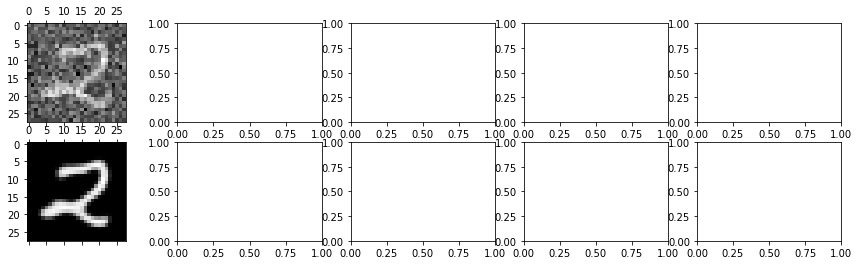

[41/50] cost: 1666.1479
[41/50] cost: 1686.4547
[41/50] cost: 1741.4575
[41/50] cost: 1702.1365
[41/50] cost: 1745.8905
[41/50] cost: 1706.3719
[41/50] cost: 1749.3190
[41/50] cost: 1664.5159
[41/50] cost: 1634.0027
[41/50] cost: 1825.6099
[41/50] cost: 1619.0010
[41/50] cost: 1739.5361
[41/50] cost: 1655.4539
[41/50] cost: 1767.9233
[41/50] cost: 1578.8945
[41/50] cost: 1632.9106
[41/50] cost: 1684.6980
[41/50] cost: 1676.9343
[41/50] cost: 1665.4877
[41/50] cost: 1705.4565
[41/50] cost: 1718.7881
[41/50] cost: 1770.2307
[41/50] cost: 1715.7007
[41/50] cost: 1741.4529
[41/50] cost: 1708.6594
[41/50] cost: 1796.9093
[41/50] cost: 1743.4574
[41/50] cost: 1648.7815
[41/50] cost: 1674.9988
[41/50] cost: 1612.0071
[41/50] cost: 1666.0132
[41/50] cost: 1677.4198
[41/50] cost: 1774.9178
[41/50] cost: 1732.7471
[41/50] cost: 1786.4069
[41/50] cost: 1763.8776
[41/50] cost: 1768.7461
[41/50] cost: 1739.6370
[41/50] cost: 1653.5798
[41/50] cost: 1744.3645
[41/50] cost: 1636.9191
[41/50] cost: 16

[41/50] cost: 1616.3005
[41/50] cost: 1793.2421
[41/50] cost: 1613.0129
[41/50] cost: 1660.4800
[41/50] cost: 1697.5702
[41/50] cost: 1623.3777
[41/50] cost: 1673.8755
[41/50] cost: 1762.9829
[41/50] cost: 1608.9650
[41/50] cost: 1712.7295
[41/50] cost: 1711.7931
[41/50] cost: 1677.2983
[41/50] cost: 1744.5803
[41/50] cost: 1714.6270
[41/50] cost: 1632.4697
[41/50] cost: 1745.4336
[41/50] cost: 1638.9983
[41/50] cost: 1699.9429
[41/50] cost: 1737.8016
[41/50] cost: 1716.5193
[41/50] cost: 1717.4340
[41/50] cost: 1686.0212
[41/50] cost: 1731.0061
[41/50] cost: 1630.2894
[41/50] cost: 1759.7445
[41/50] cost: 1684.2920
[41/50] cost: 1664.3551
[41/50] cost: 1717.9915
[41/50] cost: 1649.9128
[41/50] cost: 1651.3245
[41/50] cost: 1707.0216
[41/50] cost: 1669.7454
[41/50] cost: 1684.1538
[41/50] cost: 1656.4866
[41/50] cost: 1722.7151
[41/50] cost: 1640.8701
[41/50] cost: 1680.9618
[41/50] cost: 1649.8971
[41/50] cost: 1666.2344
[41/50] cost: 1710.2771
[41/50] cost: 1701.5491
[41/50] cost: 17

[42/50] cost: 1633.3660
[42/50] cost: 1608.7789
[42/50] cost: 1709.7090
[42/50] cost: 1679.7675
[42/50] cost: 1740.3324
[42/50] cost: 1695.0717
[42/50] cost: 1775.8661
[42/50] cost: 1803.9780
[42/50] cost: 1751.6031
[42/50] cost: 1705.2268
[42/50] cost: 1763.8735
[42/50] cost: 1850.2948
[42/50] cost: 1574.4962
[42/50] cost: 1745.1687
[42/50] cost: 1612.9341
[42/50] cost: 1777.2788
[42/50] cost: 1685.5967
[42/50] cost: 1692.7898
[42/50] cost: 1602.5703
[42/50] cost: 1647.3600
[42/50] cost: 1805.9185
[42/50] cost: 1670.5199
[42/50] cost: 1698.6918
[42/50] cost: 1726.3635
[42/50] cost: 1750.1827
[42/50] cost: 1638.3788
[42/50] cost: 1780.6730
[42/50] cost: 1714.4387
[42/50] cost: 1721.7441
[42/50] cost: 1741.2324
[42/50] cost: 1663.8008
[42/50] cost: 1526.8479
[42/50] cost: 1616.3396
[42/50] cost: 1690.5322
[42/50] cost: 1684.9191
[42/50] cost: 1635.8367
[42/50] cost: 1701.9150
[42/50] cost: 1727.7723
[42/50] cost: 1694.9556
[42/50] cost: 1711.6313
[42/50] cost: 1693.7144
[42/50] cost: 16

[43/50] cost: 1653.2670
[43/50] cost: 1751.9436
[43/50] cost: 1673.7476
[43/50] cost: 1726.4333
[43/50] cost: 1694.4956
[43/50] cost: 1716.6918
[43/50] cost: 1720.6951
[43/50] cost: 1698.8545
[43/50] cost: 1758.2844
[43/50] cost: 1750.1958
[43/50] cost: 1775.4385
[43/50] cost: 1657.6472
[43/50] cost: 1639.3740
[43/50] cost: 1692.9977
[43/50] cost: 1704.5062
[43/50] cost: 1666.6847
[43/50] cost: 1706.1484
[43/50] cost: 1713.0288
[43/50] cost: 1696.7993
[43/50] cost: 1733.5785
[43/50] cost: 1716.1267
[43/50] cost: 1617.3168
[43/50] cost: 1713.6553
[43/50] cost: 1679.3635
[43/50] cost: 1758.3315
[43/50] cost: 1728.4902
[43/50] cost: 1714.7369
[43/50] cost: 1746.1718
[43/50] cost: 1700.1780
[43/50] cost: 1607.1743
[43/50] cost: 1681.8049
[43/50] cost: 1672.2734
[43/50] cost: 1602.0109
[43/50] cost: 1630.8472
[43/50] cost: 1742.5537
[43/50] cost: 1731.4558
[43/50] cost: 1734.0015
[43/50] cost: 1716.7493
[43/50] cost: 1727.3230
[43/50] cost: 1708.9819
[43/50] cost: 1699.7567
[43/50] cost: 17

[44/50] cost: 1743.5671
[44/50] cost: 1636.1052
[44/50] cost: 1720.2102
[44/50] cost: 1600.6945
[44/50] cost: 1688.8059
[44/50] cost: 1635.7158
[44/50] cost: 1656.3875
[44/50] cost: 1659.2737
[44/50] cost: 1671.7073
[44/50] cost: 1667.9878
[44/50] cost: 1743.1874
[44/50] cost: 1721.5820
[44/50] cost: 1674.7878
[44/50] cost: 1680.5110
[44/50] cost: 1673.8673
[44/50] cost: 1656.9167
[44/50] cost: 1680.9200
[44/50] cost: 1638.5132
[44/50] cost: 1623.5020
[44/50] cost: 1718.7871
[44/50] cost: 1679.0876
[44/50] cost: 1765.2606
[44/50] cost: 1728.0725
[44/50] cost: 1667.6539
[44/50] cost: 1755.4271
[44/50] cost: 1679.2683
[44/50] cost: 1628.1938
[44/50] cost: 1733.9728
[44/50] cost: 1661.1511
[44/50] cost: 1735.8907
[44/50] cost: 1724.3826
[44/50] cost: 1688.6675
[44/50] cost: 1599.8081
[44/50] cost: 1622.5366
[44/50] cost: 1688.2986
[44/50] cost: 1750.5337
[44/50] cost: 1803.3326
[44/50] cost: 1679.6062
[44/50] cost: 1775.1216
[44/50] cost: 1681.6765
[44/50] cost: 1716.6101
[44/50] cost: 16

[45/50] cost: 1703.5693
[45/50] cost: 1634.7413
[45/50] cost: 1675.5702
[45/50] cost: 1659.7075
[45/50] cost: 1680.4542
[45/50] cost: 1661.3337
[45/50] cost: 1696.5641
[45/50] cost: 1712.3165
[45/50] cost: 1643.0762
[45/50] cost: 1692.5305
[45/50] cost: 1668.8997
[45/50] cost: 1634.8816
[45/50] cost: 1596.7532
[45/50] cost: 1711.3643
[45/50] cost: 1755.3813
[45/50] cost: 1710.7291
[45/50] cost: 1644.1593
[45/50] cost: 1624.3568
[45/50] cost: 1744.5974
[45/50] cost: 1715.2533
[45/50] cost: 1762.7191
[45/50] cost: 1608.7136
[45/50] cost: 1664.4453
[45/50] cost: 1703.7251
[45/50] cost: 1740.4199
[45/50] cost: 1729.8284
[45/50] cost: 1660.3601
[45/50] cost: 1531.8636
[45/50] cost: 1651.0508
[45/50] cost: 1752.0690
[45/50] cost: 1753.8438
[45/50] cost: 1723.0503
[45/50] cost: 1732.7551
[45/50] cost: 1673.1730
[45/50] cost: 1749.0573
[45/50] cost: 1686.3547
[45/50] cost: 1648.2664
[45/50] cost: 1692.1937
[45/50] cost: 1738.5186
[45/50] cost: 1711.4098
[45/50] cost: 1739.5303
[45/50] cost: 17

[45/50] cost: 1668.0586
[45/50] cost: 1637.1244
[45/50] cost: 1632.7837
[45/50] cost: 1701.1461
[45/50] cost: 1671.1494
[45/50] cost: 1737.7401
[45/50] cost: 1702.4731
[45/50] cost: 1750.7039
[45/50] cost: 1685.3801
[45/50] cost: 1775.1108
[45/50] cost: 1715.6775
[45/50] cost: 1755.5552
[45/50] cost: 1665.1300
[45/50] cost: 1702.4637
[45/50] cost: 1726.5463
[45/50] cost: 1646.3711
[45/50] cost: 1612.4410
[45/50] cost: 1702.3583
[45/50] cost: 1677.1841
[45/50] cost: 1629.1495
[45/50] cost: 1662.9731
[45/50] cost: 1671.0839
[45/50] cost: 1719.1422
[45/50] cost: 1762.4261
[45/50] cost: 1710.9957
[45/50] cost: 1761.9072
[45/50] cost: 1715.6052
[45/50] cost: 1642.9741
[45/50] cost: 1653.2075
[45/50] cost: 1651.6437
[45/50] cost: 1655.7423
[45/50] cost: 1608.2261
[45/50] cost: 1702.6055
[45/50] cost: 1644.7723
[45/50] cost: 1625.5979
[45/50] cost: 1712.1697
[45/50] cost: 1668.6394
[45/50] cost: 1689.1570
[45/50] cost: 1768.9756
[45/50] cost: 1751.2959
[45/50] cost: 1687.3337
[45/50] cost: 16

[46/50] cost: 1650.9232
[46/50] cost: 1618.6482
[46/50] cost: 1635.2407
[46/50] cost: 1669.7222
[46/50] cost: 1732.1045
[46/50] cost: 1612.6157
[46/50] cost: 1690.9779
[46/50] cost: 1647.2682
[46/50] cost: 1682.7480
[46/50] cost: 1610.8329
[46/50] cost: 1659.5114
[46/50] cost: 1663.3442
[46/50] cost: 1680.9460
[46/50] cost: 1679.7086
[46/50] cost: 1756.8984
[46/50] cost: 1782.7483
[46/50] cost: 1686.5339
[46/50] cost: 1690.0211
[46/50] cost: 1622.7397
[46/50] cost: 1708.6866
[46/50] cost: 1701.5396
[46/50] cost: 1693.2633
[46/50] cost: 1654.4309
[46/50] cost: 1561.5604
[46/50] cost: 1718.9480
[46/50] cost: 1720.1228
[46/50] cost: 1691.9374
[46/50] cost: 1731.7539
[46/50] cost: 1680.5927
[46/50] cost: 1772.4336
[46/50] cost: 1654.6519
[46/50] cost: 1756.1675
[46/50] cost: 1656.0645
[46/50] cost: 1679.3977
[46/50] cost: 1648.5029
[46/50] cost: 1649.1038
[46/50] cost: 1616.1934
[46/50] cost: 1806.6492
[46/50] cost: 1681.6342
[46/50] cost: 1802.7189
[46/50] cost: 1725.5966
[46/50] cost: 17

[47/50] cost: 1720.5146
[47/50] cost: 1611.0103
[47/50] cost: 1613.0275
[47/50] cost: 1734.2842
[47/50] cost: 1695.7559
[47/50] cost: 1700.1597
[47/50] cost: 1611.6174
[47/50] cost: 1670.8015
[47/50] cost: 1740.4304
[47/50] cost: 1733.6036
[47/50] cost: 1762.5446
[47/50] cost: 1614.0818
[47/50] cost: 1694.5964
[47/50] cost: 1686.4756
[47/50] cost: 1625.8398
[47/50] cost: 1667.6278
[47/50] cost: 1668.7330
[47/50] cost: 1746.2488
[47/50] cost: 1702.2683
[47/50] cost: 1679.3511
[47/50] cost: 1623.4424
[47/50] cost: 1704.4697
[47/50] cost: 1694.6354
[47/50] cost: 1663.3613
[47/50] cost: 1583.3030
[47/50] cost: 1674.7490
[47/50] cost: 1631.9261
[47/50] cost: 1702.1865
[47/50] cost: 1582.3475
[47/50] cost: 1632.1266
[47/50] cost: 1703.1495
[47/50] cost: 1718.1742
[47/50] cost: 1773.1650
[47/50] cost: 1703.5220
[47/50] cost: 1777.3953
[47/50] cost: 1707.0454
[47/50] cost: 1656.6403
[47/50] cost: 1778.4126
[47/50] cost: 1643.8131
[47/50] cost: 1638.4375
[47/50] cost: 1681.3096
[47/50] cost: 18

[48/50] cost: 1561.3018
[48/50] cost: 1692.6484
[48/50] cost: 1733.4907
[48/50] cost: 1780.4375
[48/50] cost: 1784.8326
[48/50] cost: 1578.1500
[48/50] cost: 1675.3887
[48/50] cost: 1642.9611
[48/50] cost: 1687.0605
[48/50] cost: 1733.4808
[48/50] cost: 1700.9075
[48/50] cost: 1643.5508
[48/50] cost: 1805.0208
[48/50] cost: 1758.1641
[48/50] cost: 1670.2458
[48/50] cost: 1652.8386
[48/50] cost: 1674.0133
[48/50] cost: 1661.7418
[48/50] cost: 1654.8760
[48/50] cost: 1593.6930
[48/50] cost: 1698.1554
[48/50] cost: 1670.8862
[48/50] cost: 1676.5232
[48/50] cost: 1661.4456
[48/50] cost: 1679.4371
[48/50] cost: 1608.5808
[48/50] cost: 1610.0388
[48/50] cost: 1681.6744
[48/50] cost: 1729.6765
[48/50] cost: 1616.6289
[48/50] cost: 1798.1761
[48/50] cost: 1779.4974
[48/50] cost: 1682.3169
[48/50] cost: 1751.6141
[48/50] cost: 1734.4414
[48/50] cost: 1640.3052
[48/50] cost: 1643.8914
[48/50] cost: 1735.7568
[48/50] cost: 1727.0598
[48/50] cost: 1734.7896
[48/50] cost: 1680.7310
[48/50] cost: 16

[49/50] cost: 1682.0448
[49/50] cost: 1638.8899
[49/50] cost: 1693.0720
[49/50] cost: 1711.9563
[49/50] cost: 1749.2487
[49/50] cost: 1705.2886
[49/50] cost: 1686.7048
[49/50] cost: 1719.3685
[49/50] cost: 1655.3088
[49/50] cost: 1643.6875
[49/50] cost: 1669.4424
[49/50] cost: 1627.5583
[49/50] cost: 1634.5593
[49/50] cost: 1731.6495
[49/50] cost: 1698.6707
[49/50] cost: 1672.3025
[49/50] cost: 1667.8115
[49/50] cost: 1753.1854
[49/50] cost: 1655.2361
[49/50] cost: 1627.1357
[49/50] cost: 1693.6378
[49/50] cost: 1642.3169
[49/50] cost: 1660.4312
[49/50] cost: 1712.1592
[49/50] cost: 1662.6328
[49/50] cost: 1721.4319
[49/50] cost: 1639.7314
[49/50] cost: 1665.6462
[49/50] cost: 1641.7358
[49/50] cost: 1625.1746
[49/50] cost: 1742.3423
[49/50] cost: 1726.6860
[49/50] cost: 1681.8315
[49/50] cost: 1650.3904
[49/50] cost: 1718.7253
[49/50] cost: 1633.1833
[49/50] cost: 1674.7784
[49/50] cost: 1615.7709
[49/50] cost: 1718.5596
[49/50] cost: 1665.9163
[49/50] cost: 1753.0953
[49/50] cost: 17

[49/50] cost: 1716.3928
[49/50] cost: 1663.8516
[49/50] cost: 1709.1318
[49/50] cost: 1646.3816
[49/50] cost: 1664.8756
[49/50] cost: 1654.3784
[49/50] cost: 1609.1168
[49/50] cost: 1668.3108
[49/50] cost: 1685.6582
[49/50] cost: 1669.5844
[49/50] cost: 1682.0779
[49/50] cost: 1637.9758
[49/50] cost: 1590.2780
[49/50] cost: 1608.9238
[49/50] cost: 1722.8245
[49/50] cost: 1610.4358
[49/50] cost: 1618.5433
[49/50] cost: 1697.4927
[49/50] cost: 1679.6610
[49/50] cost: 1655.6428
[49/50] cost: 1746.3613
[49/50] cost: 1708.9628
[49/50] cost: 1628.4252
[49/50] cost: 1672.4519
[49/50] cost: 1776.4230
[49/50] cost: 1658.0999
[49/50] cost: 1753.6224
[49/50] cost: 1606.0887
[49/50] cost: 1645.5442
[49/50] cost: 1667.1345
[49/50] cost: 1670.0911
[49/50] cost: 1741.4414
[49/50] cost: 1721.2244
[49/50] cost: 1700.6422
[49/50] cost: 1708.6678
[49/50] cost: 1582.8351
[49/50] cost: 1710.1125
[49/50] cost: 1687.3921
[49/50] cost: 1705.5812
[49/50] cost: 1592.6162
[49/50] cost: 1652.1071
[49/50] cost: 16

In [61]:
# 完整代码
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data

from tensorflow.python.framework import ops
import warnings
import random
import os

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
ops.reset_default_graph()

# LOAD PACKAGES
mnist = input_data.read_data_sets("data/", one_hot=True)
trainimgs = mnist.train.images
trainlabels = mnist.train.labels
testimgs = mnist.test.images
testlabels = mnist.test.labels
ntrain = trainimgs.shape[0]
ntest = testimgs.shape[0]
dim = trainimgs.shape[1]
nout = trainlabels.shape[1]

print("Packages loaded")
# WEIGHT AND BIASES
n1 = 16
n2 = 32
n3 = 64
ksize = 5

weights = {
    'ce1': tf.Variable(tf.random_normal([ksize, ksize, 1, n1], stddev=0.1)),
    'ce2': tf.Variable(tf.random_normal([ksize, ksize, n1, n2], stddev=0.1)),
    'ce3': tf.Variable(tf.random_normal([ksize, ksize, n2, n3], stddev=0.1)),
    'cd3': tf.Variable(tf.random_normal([ksize, ksize, n2, n3], stddev=0.1)),
    'cd2': tf.Variable(tf.random_normal([ksize, ksize, n1, n2], stddev=0.1)),
    'cd1': tf.Variable(tf.random_normal([ksize, ksize, 1, n1], stddev=0.1))
}
biases = {
    'be1': tf.Variable(tf.random_normal([n1], stddev=0.1)),
    'be2': tf.Variable(tf.random_normal([n2], stddev=0.1)),
    'be3': tf.Variable(tf.random_normal([n3], stddev=0.1)),
    'bd3': tf.Variable(tf.random_normal([n2], stddev=0.1)),
    'bd2': tf.Variable(tf.random_normal([n1], stddev=0.1)),
    'bd1': tf.Variable(tf.random_normal([1], stddev=0.1))
}


def cae(_X, _W, _b, _keepprob):
    # 最初的图像为784像素，必须变形为大小为28 × 28的矩阵，供下一个卷积层进行进一步处理
    _input_r = tf.reshape(_X, shape=[-1, 28, 28, 1])
    
    # Encoder
    _ce1 = tf.nn.sigmoid(tf.add(tf.nn.conv2d(_input_r, _W['ce1'], strides=[1, 2, 2, 1], padding='SAME'), _b['be1']))
    _ce1 = tf.nn.dropout(_ce1, _keepprob)
    _ce2 = tf.nn.sigmoid(tf.add(tf.nn.conv2d(_ce1, _W['ce2'], strides=[1, 2, 2, 1], padding='SAME'), _b['be2']))
    _ce2 = tf.nn.dropout(_ce2, _keepprob)
    _ce3 = tf.nn.sigmoid(tf.add(tf.nn.conv2d(_ce2, _W['ce3'], strides=[1, 2, 2, 1], padding='SAME'), _b['be3']))
    _ce3 = tf.nn.dropout(_ce3, _keepprob)
    
    # Decoder，tf.shape(_X)[0]=1
    _cd3 = tf.nn.sigmoid(tf.add(tf.nn.conv2d_transpose(_ce3, _W['cd3'], tf.stack([tf.shape(_X)[0], 7, 7, n2]), strides=[1, 2, 2, 1], padding='SAME'), _b['bd3']))
    _cd3 = tf.nn.dropout(_cd3, _keepprob)
    _cd2 = tf.nn.sigmoid(tf.add(tf.nn.conv2d_transpose(_cd3, _W['cd2'], tf.stack([tf.shape(_X)[0], 14, 14, n1]), strides=[1, 2, 2, 1], padding='SAME'), _b['bd2']))
    _cd2 = tf.nn.dropout(_cd2, _keepprob)
    _cd1 = tf.nn.sigmoid(tf.add(tf.nn.conv2d_transpose(_cd2, _W['cd1'], tf.stack([tf.shape(_X)[0], 28, 28, 1]), strides=[1, 2, 2, 1], padding='SAME'), _b['bd1']))
    _cd1 = tf.nn.dropout(_cd1, _keepprob)
    _out = _cd1
    return _out

print("Network ready")
x = tf.placeholder(tf.float32, [None, dim])
y = tf.placeholder(tf.float32, [None, dim])
keepprob = tf.placeholder(tf.float32)
pred = cae(x, weights, biases, keepprob)  # ['out']
cost = tf.reduce_sum(tf.square(cae(x, weights, biases, keepprob)- tf.reshape(y, shape=[-1, 28, 28, 1])))

learning_rate = 0.001
optm = tf.train.AdamOptimizer(learning_rate).minimize(cost)
init = tf.global_variables_initializer()

print("Functions ready")
sess = tf.Session()
sess.run(init)

# mean_img = np.mean(mnist.train.images, axis=0)
mean_img = np.zeros((784))
# Fit all training data
batch_size = 128
n_epochs = 50
print("Strart training..")

for epoch_i in range(n_epochs):
    for batch_i in range(mnist.train.num_examples // batch_size):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        trainbatch = np.array([img - mean_img for img in batch_xs])
        trainbatch_noisy = trainbatch + 0.3 * np.random.randn(
        trainbatch.shape[0], 784)
        sess.run(optm, feed_dict={x: trainbatch_noisy, y: trainbatch, keepprob: 0.7})
        print("[%02d/%02d] cost: %.4f" % (epoch_i, n_epochs, sess.run(cost, feed_dict={x: trainbatch_noisy, y: trainbatch, keepprob: 1.})))

    if (epoch_i % 10) == 0:
        n_examples = 5
        test_xs, _ = mnist.test.next_batch(n_examples)
        test_xs_noisy = test_xs + 0.3 * np.random.randn(
        test_xs.shape[0], 784)
        recon = sess.run(pred, feed_dict={x: test_xs_noisy,keepprob: 1.})
        fig, axs = plt.subplots(2, n_examples, figsize=(15, 4))

        for example_i in range(n_examples):
             axs[0][example_i].matshow(np.reshape(test_xs_noisy[example_i, :], (28, 28)), cmap=plt.get_cmap('gray'))
             axs[1][example_i].matshow(np.reshape(np.reshape(recon[example_i, ...], (784,))+ mean_img, (28, 28)), cmap=plt.get_cmap('gray'))
             plt.show()
